## ***Flujo del EDA en Python***

# Paso 1. Conexion y carga de la base de datos

In [1]:
# Configuración de la conexión a la base de datos

HOST = "localhost"
PORT = "5432"
DATABSE = "2. PremierLeague"
USER = "admin"
PASSWORD = "GadumUNITEC123"

In [2]:
# Imports

import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import missingno as msno
import psycopg2
import seaborn as sns

In [3]:
# Conexion a la base de datos

def get_engine(host, port, db, user, password):
    url = f"postgresql://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(url)
    return engine

engine = None
try:
    engine = get_engine(HOST, PORT, DATABSE, USER, PASSWORD)
    print("Engine creado. Prueba de conexión")
    with engine.connect() as connection:
        result = connection.execute("SELECT 1")
        print("Conexión exitosa:", result.fetchone())
except Exception as e:
    print("Error al conectar a la base de datos:", e)

Engine creado. Prueba de conexión
Error al conectar a la base de datos: Not an executable object: 'SELECT 1'


In [4]:
# Consultas a la base de datos

q_team_season = """
SELECT 
    id, season_id, team_id, team_name, matches_played,
    -- Estadísticas básicas
    ttl_gls, ttl_ast, ttl_non_pen_gls, ttl_xg, ttl_xag, 
    ttl_pk_made, ttl_pk_att, ttl_yellow_cards, ttl_red_cards,
    avg_gls, avg_ast, avg_non_pen_gls, avg_xg, avg_xag,
    -- Estadísticas de porteros
    ttl_gls_ag, avg_gls_ag, sot_ag, ttl_saves, clean_sheets, 
    pk_att_ag, pk_made_ag, pk_saved,
    -- Estadísticas de tiros
    ttl_sho, ttl_sot, pct_sot, avg_sho, gls_per_sot, ttl_gls_xg_diff,
    -- Estadísticas de pases
    ttl_pass_cmp, pct_pass_cmp, ttl_pass_prog, ttl_key_passes, 
    ttl_pass_opp_box, ttl_cross_opp_box,
    -- Tipos de pases
    ttl_pass_live, ttl_pass_dead, ttl_pass_fk, ttl_through_balls, 
    ttl_switches, ttl_crosses, ttl_pass_offsides, ttl_pass_blocked, 
    ttl_throw_ins, ttl_ck,
    -- Estadísticas defensivas
    ttl_tkl, ttl_tkl_won, ttl_tkl_drb, ttl_tkl_drb_att, pct_tkl_drb_suc, 
    ttl_blocks, ttl_sh_blocked, ttl_int, ttl_clearances, ttl_def_error,
    -- Estadísticas de posesión
    avg_poss, ttl_touches, ttl_take_on_att, ttl_take_on_suc, 
    ttl_carries, ttl_carries_miscontrolled, ttl_carries_dispossessed, 
    ttl_pass_recvd, ttl_pass_prog_rcvd,
    -- Tiempo de juego
    avg_age, avg_min_starter,
    -- Misceláneas
    ttl_fls_ag, ttl_fls_for, ttl_offside, ttl_og, 
    ttl_ball_recov, ttl_air_dual_won, ttl_air_dual_lost
FROM team_season_stats;
"""

q_team_match = """
SELECT
id, match_id, season_id, team_id, team_name, home_away, ttl_gls, ttl_xg, ttl_sh AS ttl_sh, ttl_sot, pct_sot, ttl_gls_ag, ttl_saves, clean_sheets,
avg_poss, ttl_pass_prog, ttl_key_passes, ttl_cross_opp_box, ttl_take_on_suc, ttl_carries, ttl_yellow_cards, ttl_red_cards
FROM team_match_stats;
"""

q_matches = """
SELECT 
match_id, season_id, matchday, home_team, home_team_id, home_team_score, away_team, away_team_id, away_team_score, date_game
FROM matches_registered;
"""

q_team_meta = "SELECT team_id, team_name FROM team_meta;"
q_data_league = "SELECT season_id, competition_name, squads_count, champion FROM data_league;"

In [5]:
# Carga de datos en DataFrames

try: 
    df_season = pd.read_sql(q_team_season, engine)
    df_match = pd.read_sql(q_team_match, engine)
    df_matches_reg = pd.read_sql(q_matches, engine)
    df_meta = pd.read_sql(q_team_meta, engine)
    df_league = pd.read_sql(q_data_league, engine)
    print("Tablas cargas: ", list(map(len, [df_season, df_match, df_matches_reg, df_meta, df_league])))
except Exception as e:
    print("No se pudieron cargar las tablas automaticamente. Error:", e)
    df_season = pd.DataFrame()
    df_match = pd.DataFrame()
    df_matches_reg = pd.DataFrame()
    df_meta = pd.DataFrame()
    df_league = pd.DataFrame()

Tablas cargas:  [160, 6070, 3038, 32, 127]


In [6]:
# Utilidades rapidas

def show_head(df, name='df'):
    print(f"--- {name} HEAD (n={len(df)}) ---")
    display(df.head())

def save_fig(fig, fname):
    outdir = "eda_outputs"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, fname)
    fig.savefig(path, bbox_inches='tight', dpi = 150)
    print("Guardado en: ", path)

In [7]:
# Revisión inicial y resumen de columnas
for name, df in [('team_season_stats', df_season), ('team_match_stats', df_match), ('matches_registered', df_matches_reg)]:
    print('\n', name, '-> filas:', len(df), 'columnas:', list(df.columns)[:10])


print('\nNulos por tabla:')
print('team_season_stats:\n', df_season.isnull().sum())
print('\nteam_match_stats:\n', df_match.isnull().sum())
print('\nmatches_registered:\n', df_matches_reg.isnull().sum())


 team_season_stats -> filas: 160 columnas: ['id', 'season_id', 'team_id', 'team_name', 'matches_played', 'ttl_gls', 'ttl_ast', 'ttl_non_pen_gls', 'ttl_xg', 'ttl_xag']

 team_match_stats -> filas: 6070 columnas: ['id', 'match_id', 'season_id', 'team_id', 'team_name', 'home_away', 'ttl_gls', 'ttl_xg', 'ttl_sh', 'ttl_sot']

 matches_registered -> filas: 3038 columnas: ['match_id', 'season_id', 'matchday', 'home_team', 'home_team_id', 'home_team_score', 'away_team', 'away_team_id', 'away_team_score', 'date_game']

Nulos por tabla:
team_season_stats:
 id                   0
season_id            0
team_id              0
team_name            0
matches_played       0
                    ..
ttl_offside          0
ttl_og               0
ttl_ball_recov       0
ttl_air_dual_won     0
ttl_air_dual_lost    0
Length: 77, dtype: int64

team_match_stats:
 id                   0
match_id             0
season_id            0
team_id              0
team_name            0
home_away            0
ttl_gls   

# Paso 2. Limpieza inicial

In [8]:
# Cargar tablas principales

team_stats = pd.read_sql('SELECT * FROM team_season_stats;', engine)
matches = pd.read_sql('SELECT * FROM matches_registered;', engine)
teams = pd.read_sql('SELECT * FROM team_meta;', engine)
league = pd.read_sql('SELECT * FROM data_league;', engine)

In [9]:
# Limpieza Inicial

print("Shape inicial team_stats:", team_stats.shape)
print("Shape inicial matches:", matches.shape)

Shape inicial team_stats: (160, 78)
Shape inicial matches: (3038, 11)


In [10]:
# 1. Eliminar duplicados

total_dups_team_stats = team_stats.duplicated(subset=['season_id', 'team_id']).sum()
team_stats = team_stats.drop_duplicates(subset=['season_id', 'team_id'])

In [11]:
# 2. Revisar valores nulos

nulls_team_stats = team_stats.isnull().sum().sort_values(ascending=False)
nulls_matches = matches.isnull().sum().sort_values(ascending=False)

In [12]:
# 3. Validar tipos de datos
print(team_stats.dtypes.head(10))

id                   int64
season_id           object
team_id             object
team_name           object
matches_played       int64
ttl_gls              int64
ttl_ast              int64
ttl_non_pen_gls      int64
ttl_xg             float64
ttl_xag            float64
dtype: object


In [13]:
# 4. Verificar consistencia de IDs
missing_teams = team_stats[~team_stats['team_id'].isin(teams['team_id'])]
print(f"Equipos sin metadatos: {missing_teams.shape[0]}")

Equipos sin metadatos: 0


In [14]:
# 5. Rellenar o eliminar datos faltantes numéricos
numeric_cols = team_stats.select_dtypes(include=['float64','int64']).columns
team_stats[numeric_cols] = team_stats[numeric_cols].fillna(0)

In [15]:
# 6. Guardar dataframe limpio
# Eliminar columnas innecesarias si existen
columns_to_remove = ['created_at']
team_stats_clean = team_stats.drop(columns=[col for col in columns_to_remove if col in team_stats.columns], errors='ignore')

# Crear directorio si no existe
os.makedirs('eda_outputsPremierLeague', exist_ok=True)

# Guardar
table_cleaned_path = 'eda_outputsPremierLeague/team_season_stats_cleaned.csv'
team_stats_clean.to_csv(table_cleaned_path, index=False)

# Paso 3. Estadisticas descriptivas

In [16]:
# Cargar los datos limpios 
table_cleaned_path = 'eda_outputsPremierLeague/team_season_stats_cleaned.csv'
team_stats = pd.read_csv(table_cleaned_path)

In [17]:
# Función para crear directorio por equipo
def create_team_directory(team_id, team_name):
    """Crear directorio específico para cada equipo"""
    # Limpiar el nombre del equipo para usar como nombre de carpeta
    clean_name = "".join(c for c in team_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
    clean_name = clean_name.replace(' ', '_')
    
    team_dir = f'eda_outputsPremierLeague/team_{team_id}_{clean_name}'
    os.makedirs(team_dir, exist_ok=True)
    return team_dir

# Función para guardar figura por equipo
def save_team_fig(fig, team_dir, filename):
    """Guardar figura en el directorio del equipo"""
    path = os.path.join(team_dir, filename)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    plt.close(fig)  # Cerrar para liberar memoria
    return path

In [27]:
# 1. Análisis descriptivo por equipo
def analyze_team_statistics(team_data, team_id, team_name):
    """Análisis estadístico completo para un equipo específico"""
    
    # Crear directorio del equipo
    team_dir = create_team_directory(team_id, team_name)
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS ESTADÍSTICO - {team_name} (ID: {team_id})")
    print(f"{'='*60}")
    
    # Variables clave para análisis
    key_offensive = ['ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_xag', 'ttl_sho', 'ttl_sot']
    key_defensive = ['ttl_gls_ag', 'clean_sheets', 'ttl_tkl', 'ttl_int', 'ttl_clearances']
    key_possession = ['avg_poss', 'ttl_pass_cmp', 'ttl_pass_prog', 'ttl_key_passes']
    
    # Resumen estadístico
    print(f"Temporadas analizadas: {len(team_data)}")
    print(f"Seasons: {', '.join(team_data['season_id'].astype(str))}")
    
    # 1.1 Estadísticas ofensivas
    if all(col in team_data.columns for col in key_offensive):
        # print(f"\n--- ESTADÍSTICAS OFENSIVAS ---")
        offensive_stats = team_data[key_offensive].describe()
        # print(offensive_stats.round(2))
        
        # Gráfico evolución ofensiva
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'{team_name} - Evolución Ofensiva por Temporada', fontsize=14)
        
        axes[0,0].plot(team_data['season_id'], team_data['ttl_gls'], marker='o', color='red')
        axes[0,0].set_title('Goles Totales')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        axes[0,1].plot(team_data['season_id'], team_data['ttl_ast'], marker='o', color='blue')
        axes[0,1].set_title('Asistencias Totales')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        axes[1,0].plot(team_data['season_id'], team_data['ttl_xg'], marker='o', color='green')
        axes[1,0].set_title('Expected Goals (xG)')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        axes[1,1].plot(team_data['season_id'], team_data['ttl_sho'], marker='o', color='orange')
        axes[1,1].set_title('Tiros Totales')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        save_team_fig(fig, team_dir, 'evolucion_ofensiva.png')
    
    # 1.2 Estadísticas defensivas
    if all(col in team_data.columns for col in key_defensive):
        # print(f"\n--- ESTADÍSTICAS DEFENSIVAS ---")
        defensive_stats = team_data[key_defensive].describe()
        # print(defensive_stats.round(2))
        
        # Gráfico evolución defensiva
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'{team_name} - Evolución Defensiva por Temporada', fontsize=14)
        
        axes[0,0].plot(team_data['season_id'], team_data['ttl_gls_ag'], marker='o', color='red')
        axes[0,0].set_title('Goles Concedidos')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        axes[0,1].plot(team_data['season_id'], team_data['clean_sheets'], marker='o', color='green')
        axes[0,1].set_title('Portería en Cero')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        axes[1,0].plot(team_data['season_id'], team_data['ttl_tkl'], marker='o', color='blue')
        axes[1,0].set_title('Tackles Totales')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        axes[1,1].plot(team_data['season_id'], team_data['ttl_int'], marker='o', color='purple')
        axes[1,1].set_title('Intercepciones')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        save_team_fig(fig, team_dir, 'evolucion_defensiva.png')
    
    # 1.3 Estadísticas de posesión
    if all(col in team_data.columns for col in key_possession):
        # print(f"\n--- ESTADÍSTICAS DE POSESIÓN ---")
        possession_stats = team_data[key_possession].describe()
        # print(possession_stats.round(2))
        
        # Gráfico evolución posesión
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle(f'{team_name} - Evolución Posesión por Temporada', fontsize=14)
        
        axes[0,0].plot(team_data['season_id'], team_data['avg_poss'], marker='o', color='green')
        axes[0,0].set_title('Posesión Promedio (%)')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        axes[0,1].plot(team_data['season_id'], team_data['ttl_pass_cmp'], marker='o', color='blue')
        axes[0,1].set_title('Pases Completados')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        axes[1,0].plot(team_data['season_id'], team_data['ttl_pass_prog'], marker='o', color='orange')
        axes[1,0].set_title('Pases Progresivos')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        axes[1,1].plot(team_data['season_id'], team_data['ttl_key_passes'], marker='o', color='red')
        axes[1,1].set_title('Pases Clave')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        save_team_fig(fig, team_dir, 'evolucion_posesion.png')
    
    
# 1.4 Radar Chart de rendimiento general y por temporada
    if len(team_data) > 0:
        # Radar Chart GENERAL (promedio de todas las temporadas)
        radar_metrics_general = {
            'Goles': team_data['ttl_gls'].mean(),
            'Asistencias': team_data['ttl_ast'].mean(),
            'xG': team_data['ttl_xg'].mean(),
            'Posesión': team_data['avg_poss'].mean(),
            'Pases Clave': team_data['ttl_key_passes'].mean(),
            'Clean Sheets': team_data['clean_sheets'].mean(),
            'Tackles': team_data['ttl_tkl'].mean(),
            'Intercepciones': team_data['ttl_int'].mean()
        }
        
        # Normalizar valores para el radar (0-100)
        max_values = {
            'Goles': 100, 'Asistencias': 50, 'xG': 80, 'Posesión': 80,
            'Pases Clave': 300, 'Clean Sheets': 20, 'Tackles': 500, 'Intercepciones': 400
        }
        
        normalized_values_general = [min(100, (radar_metrics_general[key]/max_values[key])*100) for key in radar_metrics_general.keys()]
        
        # Crear radar chart GENERAL
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
        
        angles = np.linspace(0, 2*np.pi, len(radar_metrics_general), endpoint=False).tolist()
        normalized_values_general += normalized_values_general[:1]  # Cerrar el polígono
        angles += angles[:1]
        
        ax.plot(angles, normalized_values_general, 'o-', linewidth=2, color='blue')
        ax.fill(angles, normalized_values_general, alpha=0.25, color='blue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(radar_metrics_general.keys())
        ax.set_ylim(0, 100)
        ax.set_title(f'{team_name} - Perfil de Rendimiento GENERAL\n(Promedio todas las temporadas)', 
                    pad=20, fontsize=12)
        
        save_team_fig(fig, team_dir, 'radar_rendimiento_general.png')
        
        # Radar Charts POR TEMPORADA
        seasons = sorted(team_data['season_id'].unique())
        n_seasons = len(seasons)
        
        if n_seasons > 1:
            # Crear subplots para múltiples temporadas
            cols = 3  # 3 columnas
            rows = (n_seasons + cols - 1) // cols  # Calcular filas necesarias
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows), 
                                    subplot_kw=dict(projection='polar'))
            fig.suptitle(f'{team_name} - Perfil de Rendimiento POR TEMPORADA', fontsize=16)
            
            # Aplanar axes si hay múltiples filas
            if rows > 1:
                axes = axes.flatten()
            elif n_seasons == 1:
                axes = [axes]
            
            for i, season in enumerate(seasons):
                season_data = team_data[team_data['season_id'] == season].iloc[0]
                
                # Métricas para esta temporada
                radar_metrics_season = {
                    'Goles': season_data['ttl_gls'],
                    'Asistencias': season_data['ttl_ast'],
                    'xG': season_data['ttl_xg'],
                    'Posesión': season_data['avg_poss'],
                    'Pases Clave': season_data['ttl_key_passes'],
                    'Clean Sheets': season_data['clean_sheets'],
                    'Tackles': season_data['ttl_tkl'],
                    'Intercepciones': season_data['ttl_int']
                }
                
                normalized_values_season = [min(100, (radar_metrics_season[key]/max_values[key])*100) 
                                        for key in radar_metrics_season.keys()]
                normalized_values_season += normalized_values_season[:1]
                
                # Dibujar en el subplot correspondiente
                ax = axes[i]
                ax.plot(angles, normalized_values_season, 'o-', linewidth=2, color='red')
                ax.fill(angles, normalized_values_season, alpha=0.25, color='red')
                ax.set_xticks(angles[:-1])
                ax.set_xticklabels(radar_metrics_season.keys(), fontsize=8)
                ax.set_ylim(0, 100)
                ax.set_title(f'{season}', fontsize=10, pad=10)
            
            # Ocultar subplots vacíos si los hay
            for j in range(n_seasons, len(axes)):
                axes[j].set_visible(False)
            
            plt.tight_layout()
            save_team_fig(fig, team_dir, 'radar_rendimiento_por_temporada.png')
        
        else:
            # Si solo hay una temporada, crear un radar individual
            season_data = team_data.iloc[0]
            season = season_data['season_id']
            
            radar_metrics_season = {
                'Goles': season_data['ttl_gls'],
                'Asistencias': season_data['ttl_ast'],
                'xG': season_data['ttl_xg'],
                'Posesión': season_data['avg_poss'],
                'Pases Clave': season_data['ttl_key_passes'],
                'Clean Sheets': season_data['clean_sheets'],
                'Tackles': season_data['ttl_tkl'],
                'Intercepciones': season_data['ttl_int']
            }
            
            normalized_values_season = [min(100, (radar_metrics_season[key]/max_values[key])*100) 
                                    for key in radar_metrics_season.keys()]
            normalized_values_season += normalized_values_season[:1]
            
            fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
            ax.plot(angles, normalized_values_season, 'o-', linewidth=2, color='red')
            ax.fill(angles, normalized_values_season, alpha=0.25, color='red')
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(radar_metrics_season.keys())
            ax.set_ylim(0, 100)
            ax.set_title(f'{team_name} - Perfil de Rendimiento\nTemporada {season}', 
                        pad=20, fontsize=12)
            
            save_team_fig(fig, team_dir, f'radar_rendimiento_{season}.png')
        
    # Guardar resumen estadístico en CSV
    summary_path = os.path.join(team_dir, 'resumen_estadistico.csv')
    team_data.describe().to_csv(summary_path)

    print(f"\nArchivos guardados en: {team_dir}")
    return team_dir

In [28]:
# 2. Ejecutar análisis para todos los equipos
print("INICIANDO ANÁLISIS DESCRIPTIVO POR EQUIPO")
print("="*60)

# Obtener lista única de equipos
unique_teams = team_stats[['team_id', 'team_name']].drop_duplicates()

# Contador de progreso
total_teams = len(unique_teams)
processed_teams = 0

# Crear resumen general
general_summary = {
    'team_id': [],
    'team_name': [],
    'seasons_count': [],
    'avg_goals': [],
    'avg_goals_against': [],
    'avg_possession': [],
    'total_clean_sheets': []
}

# Procesar cada equipo
for _, team_row in unique_teams.iterrows():
    team_id = team_row['team_id']
    team_name = team_row['team_name']
    
    # Filtrar datos del equipo
    team_data = team_stats[team_stats['team_id'] == team_id].copy()
    team_data = team_data.sort_values('season_id')
    
    if len(team_data) > 0:
        # Ejecutar análisis
        team_dir = analyze_team_statistics(team_data, team_id, team_name)
        
        # Agregar al resumen general
        general_summary['team_id'].append(team_id)
        general_summary['team_name'].append(team_name)
        general_summary['seasons_count'].append(len(team_data))
        general_summary['avg_goals'].append(team_data['ttl_gls'].mean())
        general_summary['avg_goals_against'].append(team_data['ttl_gls_ag'].mean())
        general_summary['avg_possession'].append(team_data['avg_poss'].mean())
        general_summary['total_clean_sheets'].append(team_data['clean_sheets'].sum())
        
        processed_teams += 1
        print(f"Progreso: {processed_teams}/{total_teams} equipos procesados")

# Crear y guardar resumen general
general_df = pd.DataFrame(general_summary)
general_summary_path = 'eda_outputsPremierLeague/resumen_general_equipos.csv'
general_df.to_csv(general_summary_path, index=False)

print(f"\n{'='*60}")
print(f"ANÁLISIS COMPLETADO")
print(f"Equipos procesados: {processed_teams}")
print(f"Resumen general guardado en: {general_summary_path}")
print(f"{'='*60}")

INICIANDO ANÁLISIS DESCRIPTIVO POR EQUIPO

ANÁLISIS ESTADÍSTICO - Arsenal (ID: 18bb7c10)
Temporadas analizadas: 8
Seasons: 2017-2018, 2018-2019, 2019-2020, 2020-2021, 2021-2022, 2022-2023, 2023-2024, 2024-2025

Archivos guardados en: eda_outputsPremierLeague/team_18bb7c10_Arsenal
Progreso: 1/31 equipos procesados

ANÁLISIS ESTADÍSTICO - Bournemouth (ID: 4ba7cbea)
Temporadas analizadas: 6
Seasons: 2017-2018, 2018-2019, 2019-2020, 2022-2023, 2023-2024, 2024-2025

Archivos guardados en: eda_outputsPremierLeague/team_4ba7cbea_Bournemouth
Progreso: 2/31 equipos procesados

ANÁLISIS ESTADÍSTICO - Brighton (ID: d07537b9)
Temporadas analizadas: 8
Seasons: 2017-2018, 2018-2019, 2019-2020, 2020-2021, 2021-2022, 2022-2023, 2023-2024, 2024-2025

Archivos guardados en: eda_outputsPremierLeague/team_d07537b9_Brighton
Progreso: 3/31 equipos procesados

ANÁLISIS ESTADÍSTICO - Burnley (ID: 943e8050)
Temporadas analizadas: 6
Seasons: 2017-2018, 2018-2019, 2019-2020, 2020-2021, 2021-2022, 2023-2024

Arch

# Paso 4. Correlaciones

In [29]:
# 1. Función para análisis de correlaciones por equipo
def analyze_team_correlations(team_data, team_id, team_name, team_dir):
    """Análisis de correlaciones específico para un equipo"""
    
    print(f"\n--- ANÁLISIS DE CORRELACIONES - {team_name} ---")
    
    # Solo proceder si hay suficientes temporadas para correlaciones
    if len(team_data) < 3:
        print(f"Equipo {team_name} tiene solo {len(team_data)} temporadas. Se requieren al menos 3 para análisis de correlaciones.")
        return
    
    # Selección de variables relevantes para correlaciones
    cols_corr = [
        'ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_xag', 'ttl_sho', 'ttl_sot',
        'ttl_pass_cmp', 'ttl_pass_prog', 'ttl_key_passes', 'avg_poss',
        'ttl_tkl', 'ttl_int', 'ttl_clearances', 'ttl_gls_ag', 'clean_sheets',
        'ttl_yellow_cards', 'ttl_red_cards', 'pct_pass_cmp', 'pct_sot'
    ]
    
    # Filtrar solo las columnas que existen
    available_cols = [col for col in cols_corr if col in team_data.columns]
    data_corr = team_data[available_cols].copy()
    
    # 1.1 Matriz de correlación completa
    corr_matrix = data_corr.corr().round(2)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
                center=0, square=True, cbar_kws={'shrink': 0.8})
    plt.title(f'{team_name} - Matriz de Correlación General')
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'correlacion_matriz_completa.png')
    
    return corr_matrix

In [30]:
def analyze_team_offensive_correlations(team_data, team_id, team_name, team_dir):
    """Análisis de correlaciones ofensivas por equipo"""
    
    if len(team_data) < 3:
        return
    
    # Variables ofensivas
    offensive_vars = ['ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_sho', 'ttl_sot', 'ttl_key_passes']
    available_offensive = [var for var in offensive_vars if var in team_data.columns]
    
    if len(available_offensive) < 3:
        print(f"No hay suficientes variables ofensivas para {team_name}")
        return
    
    off_corr = team_data[available_offensive].corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(off_corr, annot=True, cmap='YlOrRd', fmt='.2f', 
                center=0, square=True)
    plt.title(f'{team_name} - Correlaciones Ofensivas')
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'correlacion_ofensiva.png')
    
    return off_corr

In [31]:
def analyze_team_defensive_correlations(team_data, team_id, team_name, team_dir):
    """Análisis de correlaciones defensivas por equipo"""
    
    if len(team_data) < 3:
        return
    
    # Variables defensivas
    defensive_vars = ['ttl_tkl', 'ttl_int', 'ttl_clearances', 'ttl_gls_ag', 'clean_sheets']
    available_defensive = [var for var in defensive_vars if var in team_data.columns]
    
    if len(available_defensive) < 3:
        print(f"No hay suficientes variables defensivas para {team_name}")
        return
    
    def_corr = team_data[available_defensive].corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(def_corr, annot=True, cmap='Blues', fmt='.2f', 
                center=0, square=True)
    plt.title(f'{team_name} - Correlaciones Defensivas')
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'correlacion_defensiva.png')
    
    return def_corr

In [32]:
def analyze_team_cross_correlations(team_data, team_id, team_name, team_dir):
    """Análisis de correlaciones cruzadas ofensiva vs defensiva por equipo"""
    
    if len(team_data) < 3:
        return
    
    # Variables para análisis cruzado
    cross_vars = ['ttl_gls', 'ttl_xg', 'ttl_gls_ag', 'clean_sheets']
    available_cross = [var for var in cross_vars if var in team_data.columns]
    
    if len(available_cross) < 4:
        print(f"No hay suficientes variables para análisis cruzado en {team_name}")
        return
    
    # Crear pairplot
    fig = plt.figure(figsize=(10, 8))
    
    # Usar seaborn pairplot pero guardarlo correctamente
    g = sns.pairplot(team_data[available_cross], diag_kind='hist')
    g.fig.suptitle(f'{team_name} - Relaciones Cruzadas Ofensiva vs Defensiva', y=1.02)
    
    # Guardar la figura del pairplot
    pair_path = os.path.join(team_dir, 'correlacion_cruzada.png')
    g.savefig(pair_path, bbox_inches='tight', dpi=150)
    plt.close(g.fig)
    
    return available_cross

In [33]:
# 2. Ejecutar análisis de correlaciones para todos los equipos
def run_correlation_analysis_by_team():
    """Ejecutar análisis de correlaciones para cada equipo"""
    
    print("INICIANDO ANÁLISIS DE CORRELACIONES POR EQUIPO")
    print("="*60)
    
    # Obtener lista única de equipos
    unique_teams = team_stats[['team_id', 'team_name']].drop_duplicates()
    
    # Contador de progreso
    total_teams = len(unique_teams)
    processed_teams = 0
    teams_with_correlations = 0
    
    # Resumen de correlaciones por equipo
    correlation_summary = {
        'team_id': [],
        'team_name': [],
        'seasons_analyzed': [],
        'strongest_offensive_corr': [],
        'strongest_defensive_corr': [],
        'gols_xg_correlation': []
    }
    
    # Procesar cada equipo
    for _, team_row in unique_teams.iterrows():
        team_id = team_row['team_id']
        team_name = team_row['team_name']
        
        # Filtrar datos del equipo
        team_data = team_stats[team_stats['team_id'] == team_id].copy()
        team_data = team_data.sort_values('season_id')
        
        if len(team_data) >= 3:  # Solo analizar equipos con al menos 3 temporadas
            # Crear directorio del equipo (reutilizar función)
            team_dir = create_team_directory(team_id, team_name)
            
            # Ejecutar análisis de correlaciones
            general_corr = analyze_team_correlations(team_data, team_id, team_name, team_dir)
            offensive_corr = analyze_team_offensive_correlations(team_data, team_id, team_name, team_dir)
            defensive_corr = analyze_team_defensive_correlations(team_data, team_id, team_name, team_dir)
            cross_vars = analyze_team_cross_correlations(team_data, team_id, team_name, team_dir)
            
            # Agregar al resumen
            correlation_summary['team_id'].append(team_id)
            correlation_summary['team_name'].append(team_name)
            correlation_summary['seasons_analyzed'].append(len(team_data))
            
            # Encontrar correlaciones más fuertes
            if offensive_corr is not None and len(offensive_corr) > 1:
                # Obtener la correlación más fuerte (excluyendo diagonal)
                off_vals = offensive_corr.values
                np.fill_diagonal(off_vals, 0)  # Eliminar diagonal
                max_off_corr = np.max(np.abs(off_vals))
                correlation_summary['strongest_offensive_corr'].append(max_off_corr)
            else:
                correlation_summary['strongest_offensive_corr'].append(0)
            
            if defensive_corr is not None and len(defensive_corr) > 1:
                def_vals = defensive_corr.values
                np.fill_diagonal(def_vals, 0)
                max_def_corr = np.max(np.abs(def_vals))
                correlation_summary['strongest_defensive_corr'].append(max_def_corr)
            else:
                correlation_summary['strongest_defensive_corr'].append(0)
            
            # Correlación específica goles vs xG
            if all(col in team_data.columns for col in ['ttl_gls', 'ttl_xg']):
                gols_xg_corr = team_data['ttl_gls'].corr(team_data['ttl_xg'])
                correlation_summary['gols_xg_correlation'].append(gols_xg_corr)
            else:
                correlation_summary['gols_xg_correlation'].append(0)
            
            teams_with_correlations += 1
            print(f"Correlaciones procesadas: {team_name} ({len(team_data)} temporadas)")
        
        processed_teams += 1
        print(f"Progreso: {processed_teams}/{total_teams} equipos revisados")
    
    # Crear y guardar resumen de correlaciones
    correlation_df = pd.DataFrame(correlation_summary)
    correlation_summary_path = 'eda_outputsPremierLeague/resumen_correlaciones_equipos.csv'
    correlation_df.to_csv(correlation_summary_path, index=False)
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS DE CORRELACIONES COMPLETADO")
    print(f"Equipos con suficientes datos para correlaciones: {teams_with_correlations}")
    print(f"Resumen guardado en: {correlation_summary_path}")
    print(f"{'='*60}")
    
    return correlation_df

# Ejecutar el análisis
correlation_results = run_correlation_analysis_by_team()

INICIANDO ANÁLISIS DE CORRELACIONES POR EQUIPO

--- ANÁLISIS DE CORRELACIONES - Arsenal ---
Correlaciones procesadas: Arsenal (8 temporadas)
Progreso: 1/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Bournemouth ---
Correlaciones procesadas: Bournemouth (6 temporadas)
Progreso: 2/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Brighton ---
Correlaciones procesadas: Brighton (8 temporadas)
Progreso: 3/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Burnley ---
Correlaciones procesadas: Burnley (6 temporadas)
Progreso: 4/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Chelsea ---
Correlaciones procesadas: Chelsea (8 temporadas)
Progreso: 5/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Crystal Palace ---
Correlaciones procesadas: Crystal Palace (8 temporadas)
Progreso: 6/31 equipos revisados

--- ANÁLISIS DE CORRELACIONES - Everton ---
Correlaciones procesadas: Everton (8 temporadas)
Progreso: 7/31 equipos revisados
Progreso: 8/31 equipos revisados

--- AN

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [34]:
# 3. Análisis adicional - Top correlaciones por categoría
print("\nTOP CORRELACIONES POR CATEGORÍA:")
print("-" * 50)

if len(correlation_results) > 0:
    # Top 5 equipos con correlaciones ofensivas más fuertes
    print("TOP 5 - Correlaciones ofensivas más fuertes:")
    top_offensive = correlation_results.nlargest(5, 'strongest_offensive_corr')[
        ['team_name', 'strongest_offensive_corr', 'seasons_analyzed']]
    print(top_offensive)
    
    # Top 5 equipos con correlaciones defensivas más fuertes
    print("\nTOP 5 - Correlaciones defensivas más fuertes:")
    top_defensive = correlation_results.nlargest(5, 'strongest_defensive_corr')[
        ['team_name', 'strongest_defensive_corr', 'seasons_analyzed']]
    print(top_defensive)
    
    # Top 5 equipos con mejor correlación Goles vs xG
    print("\nTOP 5 - Mejor correlación Goles vs Expected Goals:")
    top_gols_xg = correlation_results.nlargest(5, 'gols_xg_correlation')[
        ['team_name', 'gols_xg_correlation', 'seasons_analyzed']]
    print(top_gols_xg)
    
    # Equipos con más temporadas analizadas
    print("\nEquipos con más temporadas analizadas:")
    most_seasons = correlation_results.nlargest(5, 'seasons_analyzed')[
        ['team_name', 'seasons_analyzed']]
    print(most_seasons)
else:
    print("No hay datos suficientes para el análisis de correlaciones.")


TOP CORRELACIONES POR CATEGORÍA:
--------------------------------------------------
TOP 5 - Correlaciones ofensivas más fuertes:
          team_name  strongest_offensive_corr  seasons_analyzed
20     Leeds United                  0.999990                 3
22  Nott'ham Forest                  0.999955                 3
1       Bournemouth                  0.999145                 6
14          Watford                  0.998079                 4
7    Leicester City                  0.992879                 7

TOP 5 - Correlaciones defensivas más fuertes:
          team_name  strongest_defensive_corr  seasons_analyzed
20     Leeds United                  0.999376                 3
22  Nott'ham Forest                  0.999266                 3
19    Sheffield Utd                  0.989156                 3
21        Brentford                  0.970725                 4
7    Leicester City                  0.962497                 7

TOP 5 - Mejor correlación Goles vs Expected Goals:
   

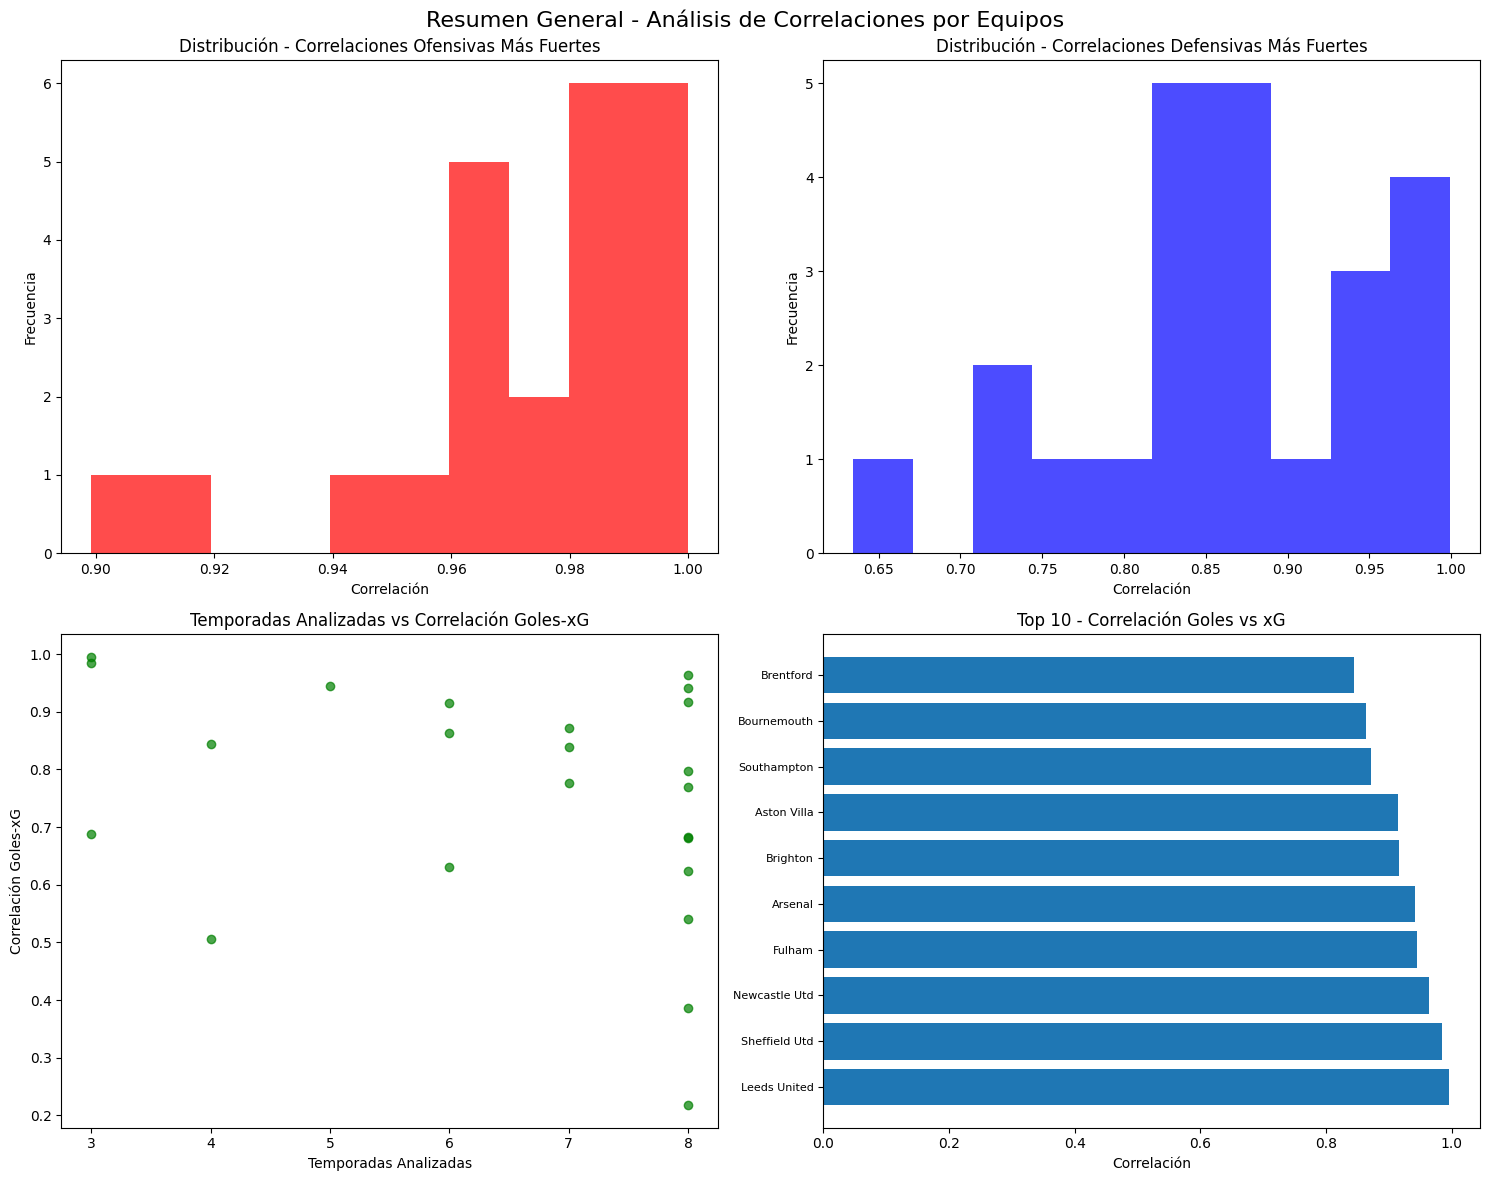

Resumen visual guardado en: eda_outputsPremierLeague/resumen_correlaciones_general.png


In [35]:
# 4. Visualización general de correlaciones
if len(correlation_results) > 0:
    # Crear visualización general de los resultados
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Resumen General - Análisis de Correlaciones por Equipos', fontsize=16)
    
    # Histograma de correlaciones ofensivas
    axes[0,0].hist(correlation_results['strongest_offensive_corr'], bins=10, alpha=0.7, color='red')
    axes[0,0].set_title('Distribución - Correlaciones Ofensivas Más Fuertes')
    axes[0,0].set_xlabel('Correlación')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Histograma de correlaciones defensivas
    axes[0,1].hist(correlation_results['strongest_defensive_corr'], bins=10, alpha=0.7, color='blue')
    axes[0,1].set_title('Distribución - Correlaciones Defensivas Más Fuertes')
    axes[0,1].set_xlabel('Correlación')
    axes[0,1].set_ylabel('Frecuencia')
    
    # Scatter plot: Temporadas vs Correlación Goles-xG
    axes[1,0].scatter(correlation_results['seasons_analyzed'], 
                      correlation_results['gols_xg_correlation'], alpha=0.7, color='green')
    axes[1,0].set_title('Temporadas Analizadas vs Correlación Goles-xG')
    axes[1,0].set_xlabel('Temporadas Analizadas')
    axes[1,0].set_ylabel('Correlación Goles-xG')
    
    # Bar plot: Top 10 equipos por correlación Goles-xG
    top_10_gxg = correlation_results.nlargest(10, 'gols_xg_correlation')
    axes[1,1].barh(range(len(top_10_gxg)), top_10_gxg['gols_xg_correlation'])
    axes[1,1].set_yticks(range(len(top_10_gxg)))
    axes[1,1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                               for name in top_10_gxg['team_name']], fontsize=8)
    axes[1,1].set_title('Top 10 - Correlación Goles vs xG')
    axes[1,1].set_xlabel('Correlación')
    
    plt.tight_layout()
    
    # Guardar resumen general
    general_path = 'eda_outputsPremierLeague/resumen_correlaciones_general.png'
    fig.savefig(general_path, bbox_inches='tight', dpi=150)
    plt.show()
    
    print(f"Resumen visual guardado en: {general_path}")

# Paso 5. Analisis Temporal y Tendencias 

In [36]:
# 1. Función para análisis temporal por equipo
def analyze_team_temporal_trends(team_data, team_id, team_name, team_dir):
    """Análisis temporal completo para un equipo específico"""
    
    print(f"\n--- ANÁLISIS TEMPORAL - {team_name} ---")
    
    # Solo proceder si hay suficientes temporadas
    if len(team_data) < 2:
        print(f"Equipo {team_name} tiene solo {len(team_data)} temporada(s). Se requieren al menos 2 para análisis temporal.")
        return
    
    # Ordenar por temporada
    team_data_sorted = team_data.sort_values('season_id').reset_index(drop=True)
    
    # 1.1 Análisis de tendencias lineales
    analyze_linear_trends(team_data_sorted, team_name, team_dir)
    
    # 1.2 Análisis de volatilidad y consistencia
    analyze_consistency_trends(team_data_sorted, team_name, team_dir)
    
    # 1.3 Análisis de patrones cíclicos
    analyze_cyclical_patterns(team_data_sorted, team_name, team_dir)
    
    # 1.4 Evolución del perfil de juego
    analyze_playing_style_evolution(team_data_sorted, team_name, team_dir)
    
    return team_data_sorted

def analyze_linear_trends(team_data, team_name, team_dir):
    """Análisis de tendencias lineales en métricas clave"""
    
    # Métricas clave para tendencias
    trend_metrics = {
        'Ofensivas': ['ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_sho'],
        'Defensivas': ['ttl_gls_ag', 'clean_sheets', 'ttl_tkl', 'ttl_int'],
        'Posesión': ['avg_poss', 'ttl_pass_cmp', 'ttl_key_passes'],
        'Disciplina': ['ttl_yellow_cards', 'ttl_red_cards']
    }
    
    # Crear índice temporal
    team_data['season_numeric'] = range(len(team_data))
    
    # Calcular tendencias
    trends_summary = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{team_name} - Tendencias Temporales por Categorías', fontsize=16)
    
    axes = axes.flatten()
    
    for idx, (category, metrics) in enumerate(trend_metrics.items()):
        if idx >= 4:  # Solo 4 subplots
            break
            
        ax = axes[idx]
        available_metrics = [m for m in metrics if m in team_data.columns]
        
        if not available_metrics:
            continue
            
        # Normalizar datos para comparación visual (escala 0-100)
        for metric in available_metrics:
            if team_data[metric].std() > 0:  # Evitar división por cero
                normalized = (team_data[metric] - team_data[metric].min()) / (team_data[metric].max() - team_data[metric].min()) * 100
                
                # Calcular tendencia lineal
                slope = np.polyfit(team_data['season_numeric'], team_data[metric], 1)[0]
                trends_summary[f"{category}_{metric}"] = slope
                
                # Graficar
                ax.plot(team_data['season_id'], normalized, marker='o', label=metric, linewidth=2)
        
        ax.set_title(f'{category}')
        ax.set_xlabel('Temporada')
        ax.set_ylabel('Valor Normalizado (0-100)')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'tendencias_temporales.png')
    
    # Guardar resumen de tendencias
    trends_df = pd.DataFrame(list(trends_summary.items()), columns=['Metric', 'Slope'])
    trends_path = os.path.join(team_dir, 'tendencias_resumen.csv')
    trends_df.to_csv(trends_path, index=False)
    
    return trends_summary

def analyze_consistency_trends(team_data, team_name, team_dir):
    """Análisis de volatilidad y consistencia temporal"""
    
    # Métricas para análisis de consistencia
    consistency_metrics = ['ttl_gls', 'ttl_gls_ag', 'avg_poss', 'ttl_xg']
    available_metrics = [m for m in consistency_metrics if m in team_data.columns]
    
    if len(available_metrics) < 2 or len(team_data) < 3:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Análisis de Consistencia Temporal', fontsize=14)
    
    # 1. Volatilidad por rolling window
    if len(team_data) >= 3:
        axes[0,0].plot(team_data['season_id'], team_data['ttl_gls'].rolling(2).std(), marker='o', color='red')
        axes[0,0].set_title('Volatilidad Goles (Rolling Std)')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Diferencias año a año
    if 'ttl_gls' in team_data.columns:
        goal_diff = team_data['ttl_gls'].diff()
        axes[0,1].bar(team_data['season_id'][1:], goal_diff[1:], color=['green' if x > 0 else 'red' for x in goal_diff[1:]])
        axes[0,1].set_title('Cambio Anual en Goles')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # 3. Coeficiente de variación por métrica
    cv_data = []
    for metric in available_metrics:
        if team_data[metric].std() > 0:
            cv = team_data[metric].std() / team_data[metric].mean()
            cv_data.append({'Metric': metric, 'CV': cv})
    
    if cv_data:
        cv_df = pd.DataFrame(cv_data)
        axes[1,0].bar(cv_df['Metric'], cv_df['CV'], color='skyblue')
        axes[1,0].set_title('Coeficiente de Variación por Métrica')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Progresión acumulada vs objetivo (ejemplo: 60 goles)
    if 'ttl_gls' in team_data.columns:
        target_goals = 60  # Meta hipotética
        cumulative_diff = (team_data['ttl_gls'] - target_goals).cumsum()
        axes[1,1].plot(team_data['season_id'], cumulative_diff, marker='o', color='purple')
        axes[1,1].axhline(y=0, color='red', linestyle='--', label=f'Meta: {target_goals} goles')
        axes[1,1].set_title('Desviación Acumulada vs Meta')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend()
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'consistencia_temporal.png')

def analyze_cyclical_patterns(team_data, team_name, team_dir):
    """Análisis de patrones cíclicos y estacionales"""
    
    if len(team_data) < 4:  # Necesitamos al menos 4 temporadas para detectar ciclos
        print(f"Se necesitan al menos 4 temporadas para análisis cíclico. {team_name} tiene {len(team_data)}")
        return
    
    # Métricas para análisis cíclico
    cyclical_metrics = ['ttl_gls', 'ttl_gls_ag', 'avg_poss', 'clean_sheets']
    available_metrics = [m for m in cyclical_metrics if m in team_data.columns and team_data[m].std() > 0]
    
    if not available_metrics:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Análisis de Patrones Cíclicos', fontsize=14)
    
    for idx, metric in enumerate(available_metrics[:4]):
        if idx >= 4:
            break
            
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        # Serie temporal con media móvil
        values = team_data[metric]
        seasons = team_data['season_id']
        
        ax.plot(seasons, values, marker='o', label='Valores reales', linewidth=2)
        
        # Media móvil si hay suficientes datos
        if len(values) >= 3:
            rolling_mean = values.rolling(window=3, center=True).mean()
            ax.plot(seasons, rolling_mean, label='Media móvil (3)', linestyle='--', alpha=0.7)
        
        # Línea de tendencia
        if len(values) > 2:
            z = np.polyfit(range(len(values)), values, 1)
            p = np.poly1d(z)
            ax.plot(seasons, p(range(len(values))), label='Tendencia', linestyle=':', alpha=0.8)
        
        ax.set_title(f'{metric}')
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'patrones_ciclicos.png')

def analyze_playing_style_evolution(team_data, team_name, team_dir):
    """Análisis de evolución del estilo de juego"""
    
    if len(team_data) < 2:
        return
    
    # Métricas que definen estilo de juego
    style_metrics = {
        'Intensidad_Ofensiva': ['ttl_sho', 'ttl_key_passes', 'ttl_cross_opp_box'],
        'Control_Juego': ['avg_poss', 'ttl_pass_cmp', 'pct_pass_cmp'],
        'Agresividad_Defensiva': ['ttl_tkl', 'ttl_int', 'ttl_fls_for'],
        'Solidez_Defensiva': ['clean_sheets', 'ttl_gls_ag', 'ttl_saves']
    }
    
    # Calcular índices compuestos
    style_indices = {}
    
    for style, metrics in style_metrics.items():
        available_style_metrics = [m for m in metrics if m in team_data.columns]
        
        if len(available_style_metrics) >= 2:
            # Normalizar y promediar
            normalized_values = []
            for metric in available_style_metrics:
                if team_data[metric].std() > 0:
                    norm_val = (team_data[metric] - team_data[metric].min()) / (team_data[metric].max() - team_data[metric].min())
                    normalized_values.append(norm_val)
            
            if normalized_values:
                style_indices[style] = np.mean(normalized_values, axis=0)
    
    if not style_indices:
        return
    
    # Visualizar evolución del estilo
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Evolución del Estilo de Juego', fontsize=14)
    
    axes = axes.flatten()
    colors = ['red', 'blue', 'green', 'purple']
    
    for idx, (style, values) in enumerate(style_indices.items()):
        if idx >= 4:
            break
            
        axes[idx].plot(team_data['season_id'], values, marker='o', color=colors[idx], linewidth=2)
        axes[idx].set_title(f'{style.replace("_", " ")}')
        axes[idx].set_ylabel('Índice Normalizado')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim(0, 1)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'evolucion_estilo_juego.png')
    
    # Guardar índices de estilo
    style_df = pd.DataFrame(style_indices)
    style_df['season_id'] = team_data['season_id'].values
    style_path = os.path.join(team_dir, 'indices_estilo_juego.csv')
    style_df.to_csv(style_path, index=False)
    
    return style_indices

In [37]:
# 2. Ejecutar análisis temporal para todos los equipos
def run_temporal_analysis_by_team():
    """Ejecutar análisis temporal para cada equipo"""
    
    print("INICIANDO ANÁLISIS TEMPORAL POR EQUIPO")
    print("="*60)
    
    # Obtener lista única de equipos
    unique_teams = team_stats[['team_id', 'team_name']].drop_duplicates()
    
    # Contador de progreso
    total_teams = len(unique_teams)
    processed_teams = 0
    teams_with_trends = 0
    
    # Resumen temporal por equipo
    temporal_summary = {
        'team_id': [],
        'team_name': [],
        'seasons_analyzed': [],
        'goal_trend': [],
        'defensive_trend': [],
        'possession_trend': [],
        'consistency_score': []
    }
    
    # Procesar cada equipo
    for _, team_row in unique_teams.iterrows():
        team_id = team_row['team_id']
        team_name = team_row['team_name']
        
        # Filtrar datos del equipo
        team_data = team_stats[team_stats['team_id'] == team_id].copy()
        team_data = team_data.sort_values('season_id')
        
        if len(team_data) >= 2:  # Al menos 2 temporadas para análisis temporal
            # Crear directorio del equipo (reutilizar función)
            team_dir = create_team_directory(team_id, team_name)
            
            # Ejecutar análisis temporal
            team_data_processed = analyze_team_temporal_trends(team_data, team_id, team_name, team_dir)
            
            # Calcular métricas de resumen
            goal_trend = 0
            defensive_trend = 0  
            possession_trend = 0
            consistency_score = 0
            
            if team_data_processed is not None and len(team_data_processed) > 2:
                # Tendencia de goles (pendiente de regresión)
                if 'ttl_gls' in team_data.columns:
                    goal_trend = np.polyfit(range(len(team_data)), team_data['ttl_gls'], 1)[0]
                
                # Tendencia defensiva (goles concedidos, invertida)
                if 'ttl_gls_ag' in team_data.columns:
                    defensive_trend = -np.polyfit(range(len(team_data)), team_data['ttl_gls_ag'], 1)[0]
                
                # Tendencia de posesión
                if 'avg_poss' in team_data.columns:
                    possession_trend = np.polyfit(range(len(team_data)), team_data['avg_poss'], 1)[0]
                
                # Score de consistencia (basado en CV de goles)
                if 'ttl_gls' in team_data.columns and team_data['ttl_gls'].std() > 0:
                    cv_goals = team_data['ttl_gls'].std() / team_data['ttl_gls'].mean()
                    consistency_score = max(0, 1 - cv_goals)  # Menor CV = mayor consistencia
            
            # Agregar al resumen
            temporal_summary['team_id'].append(team_id)
            temporal_summary['team_name'].append(team_name)
            temporal_summary['seasons_analyzed'].append(len(team_data))
            temporal_summary['goal_trend'].append(goal_trend)
            temporal_summary['defensive_trend'].append(defensive_trend)
            temporal_summary['possession_trend'].append(possession_trend)
            temporal_summary['consistency_score'].append(consistency_score)
            
            teams_with_trends += 1
            print(f"Análisis temporal procesado: {team_name} ({len(team_data)} temporadas)")
        
        processed_teams += 1
        print(f"Progreso: {processed_teams}/{total_teams} equipos revisados")
    
    # Crear y guardar resumen temporal
    temporal_df = pd.DataFrame(temporal_summary)
    temporal_summary_path = 'eda_outputsPremierLeague/resumen_temporal_equipos.csv'
    temporal_df.to_csv(temporal_summary_path, index=False)
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS TEMPORAL COMPLETADO")
    print(f"Equipos con suficientes datos temporales: {teams_with_trends}")
    print(f"Resumen guardado en: {temporal_summary_path}")
    print(f"{'='*60}")
    
    return temporal_df

# Ejecutar el análisis temporal
temporal_results = run_temporal_analysis_by_team()

INICIANDO ANÁLISIS TEMPORAL POR EQUIPO

--- ANÁLISIS TEMPORAL - Arsenal ---
Análisis temporal procesado: Arsenal (8 temporadas)
Progreso: 1/31 equipos revisados

--- ANÁLISIS TEMPORAL - Bournemouth ---
Análisis temporal procesado: Bournemouth (6 temporadas)
Progreso: 2/31 equipos revisados

--- ANÁLISIS TEMPORAL - Brighton ---
Análisis temporal procesado: Brighton (8 temporadas)
Progreso: 3/31 equipos revisados

--- ANÁLISIS TEMPORAL - Burnley ---
Análisis temporal procesado: Burnley (6 temporadas)
Progreso: 4/31 equipos revisados

--- ANÁLISIS TEMPORAL - Chelsea ---
Análisis temporal procesado: Chelsea (8 temporadas)
Progreso: 5/31 equipos revisados

--- ANÁLISIS TEMPORAL - Crystal Palace ---
Análisis temporal procesado: Crystal Palace (8 temporadas)
Progreso: 6/31 equipos revisados

--- ANÁLISIS TEMPORAL - Everton ---
Análisis temporal procesado: Everton (8 temporadas)
Progreso: 7/31 equipos revisados

--- ANÁLISIS TEMPORAL - Huddersfield ---
Se necesitan al menos 4 temporadas para a

# Paso 6. Clustering/Segmentacion

In [38]:
# Imports adicionales para clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

In [ ]:
# 1. Función para preparar datos de clustering por equipo
def prepare_clustering_data(team_stats):
    """Preparar datos para análisis de clustering"""
    
    # Variables clave para clustering (promedios por equipo)
    clustering_vars = [
        'ttl_gls', 'ttl_ast', 'ttl_xg', 'ttl_sho', 'ttl_sot',  # Ofensivas
        'ttl_gls_ag', 'clean_sheets', 'ttl_tkl', 'ttl_int',     # Defensivas
        'avg_poss', 'ttl_pass_cmp', 'ttl_key_passes',           # Posesión
        'ttl_yellow_cards', 'ttl_red_cards'                     # Disciplina
    ]
    
    # Filtrar solo variables que existen
    available_vars = [var for var in clustering_vars if var in team_stats.columns]
    
    # Crear dataset agregado por equipo (promedios)
    team_aggregates = team_stats.groupby(['team_id', 'team_name'])[available_vars].mean().reset_index()
    
    # Agregar métricas adicionales derivadas
    if all(col in team_aggregates.columns for col in ['ttl_gls', 'ttl_gls_ag']):
        team_aggregates['goal_difference'] = team_aggregates['ttl_gls'] - team_aggregates['ttl_gls_ag']
    
    if all(col in team_aggregates.columns for col in ['ttl_sot', 'ttl_gls']):
        team_aggregates['conversion_rate'] = team_aggregates['ttl_gls'] / (team_aggregates['ttl_sot'] + 1)
    
    if all(col in team_aggregates.columns for col in ['clean_sheets', 'ttl_gls_ag']):
        team_aggregates['defensive_efficiency'] = team_aggregates['clean_sheets'] / (team_aggregates['ttl_gls_ag'] + 1)
    
    return team_aggregates, available_vars

def perform_team_clustering_analysis():
    """Análisis completo de clustering para equipos"""
    
    print("INICIANDO ANÁLISIS DE CLUSTERING POR EQUIPOS")
    print("="*60)
    
    # Preparar datos
    team_data, feature_vars = prepare_clustering_data(team_stats)
    
    if len(team_data) < 3:
        print("No hay suficientes equipos para clustering")
        return None
    
    # Variables para clustering (excluir IDs y nombres)
    clustering_features = [col for col in team_data.columns if col not in ['team_id', 'team_name']]
    X = team_data[clustering_features].fillna(0)
    
    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Crear directorio para clustering
    cluster_dir = 'eda_outputsPremierLeague/clustering_analysis'
    os.makedirs(cluster_dir, exist_ok=True)
    
    # 1. Determinar número óptimo de clusters
    optimal_clusters = determine_optimal_clusters(X_scaled, cluster_dir)
    
    # 2. Aplicar K-means con número óptimo
    perform_kmeans_analysis(X_scaled, team_data, optimal_clusters, cluster_dir, clustering_features)
    
    # 3. Clustering jerárquico
    perform_hierarchical_clustering(X_scaled, team_data, cluster_dir, clustering_features)
    
    # 4. Análisis PCA para visualización
    perform_pca_analysis(X_scaled, team_data, optimal_clusters, cluster_dir)
    
    # 5. Análisis de características por cluster
    analyze_cluster_characteristics(team_data, optimal_clusters, cluster_dir, clustering_features)
    
    return team_data

def determine_optimal_clusters(X_scaled, cluster_dir):
    """Determinar número óptimo de clusters usando múltiples métodos"""
    
    max_clusters = min(10, len(X_scaled) - 1)
    
    # Método del codo (Elbow)
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertias.append(kmeans.inertia_)
        
        silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    
    # Visualizar métodos de selección
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Método del codo
    axes[0].plot(K_range, inertias, marker='o', color='blue')
    axes[0].set_title('Método del Codo')
    axes[0].set_xlabel('Número de Clusters')
    axes[0].set_ylabel('Inercia')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette Score
    axes[1].plot(K_range, silhouette_scores, marker='o', color='red')
    axes[1].set_title('Silhouette Score')
    axes[1].set_xlabel('Número de Clusters')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    cluster_selection_path = os.path.join(cluster_dir, 'cluster_selection_methods.png')
    fig.savefig(cluster_selection_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Seleccionar número óptimo (mayor silhouette score)
    optimal_k = K_range[np.argmax(silhouette_scores)]
    
    print(f"Número óptimo de clusters determinado: {optimal_k}")
    print(f"Silhouette Score: {max(silhouette_scores):.3f}")
    
    return optimal_k

def perform_kmeans_analysis(X_scaled, team_data, n_clusters, cluster_dir, features):
    """Realizar análisis K-means"""
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Agregar labels al dataframe
    team_data_clustered = team_data.copy()
    team_data_clustered['cluster'] = cluster_labels
    
    # Visualización de clusters (usando PCA para 2D)
    pca_viz = PCA(n_components=2)
    X_pca = pca_viz.fit_transform(X_scaled)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=100)
    
    # Agregar nombres de equipos
    for i, team_name in enumerate(team_data['team_name']):
        ax.annotate(team_name[:8], (X_pca[i, 0], X_pca[i, 1]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_title(f'Clusters de Equipos (K-means, k={n_clusters})')
    ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} varianza)')
    ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} varianza)')
    plt.colorbar(scatter, label='Cluster')
    
    kmeans_viz_path = os.path.join(cluster_dir, 'kmeans_clusters_visualization.png')
    fig.savefig(kmeans_viz_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Guardar resultados
    results_path = os.path.join(cluster_dir, 'kmeans_results.csv')
    team_data_clustered[['team_id', 'team_name', 'cluster']].to_csv(results_path, index=False)
    
    print(f"K-means completado. Resultados guardados en: {results_path}")
    
    return team_data_clustered

def perform_hierarchical_clustering(X_scaled, team_data, cluster_dir, features):
    """Realizar clustering jerárquico"""
    
    # Calcular matriz de distancias
    distance_matrix = pdist(X_scaled, metric='euclidean')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Crear dendrograma
    fig, ax = plt.subplots(figsize=(12, 8))
    
    dendrogram(linkage_matrix, 
              labels=team_data['team_name'].values,
              orientation='left',
              ax=ax)
    
    ax.set_title('Dendrograma - Clustering Jerárquico')
    ax.set_xlabel('Distancia')
    plt.tight_layout()
    
    dendrogram_path = os.path.join(cluster_dir, 'hierarchical_dendrogram.png')
    fig.savefig(dendrogram_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Clustering jerárquico con número fijo de clusters
    hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    # Guardar resultados jerárquicos
    team_data_hierarchical = team_data.copy()
    team_data_hierarchical['hierarchical_cluster'] = hierarchical_labels
    
    hierarchical_results_path = os.path.join(cluster_dir, 'hierarchical_results.csv')
    team_data_hierarchical[['team_id', 'team_name', 'hierarchical_cluster']].to_csv(
        hierarchical_results_path, index=False)
    
    print(f"Clustering jerárquico completado. Dendrograma guardado en: {dendrogram_path}")
    
    return team_data_hierarchical

def perform_pca_analysis(X_scaled, team_data, n_clusters, cluster_dir):
    """Análisis de Componentes Principales"""
    
    # PCA completo
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    
    # Varianza explicada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    # Visualización de varianza explicada
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Varianza por componente
    axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
    axes[0].set_title('Varianza Explicada por Componente')
    axes[0].set_xlabel('Componente Principal')
    axes[0].set_ylabel('Varianza Explicada')
    
    # Varianza acumulada
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% Varianza')
    axes[1].set_title('Varianza Acumulada')
    axes[1].set_xlabel('Número de Componentes')
    axes[1].set_ylabel('Varianza Acumulada')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    pca_variance_path = os.path.join(cluster_dir, 'pca_variance_analysis.png')
    fig.savefig(pca_variance_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Biplot (primeros 2 componentes)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Aplicar K-means para colorear
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=100)
    
    # Agregar nombres de equipos
    for i, team_name in enumerate(team_data['team_name']):
        ax.annotate(team_name[:8], (X_pca[i, 0], X_pca[i, 1]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_title('Biplot PCA - Equipos por Clusters')
    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} varianza)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} varianza)')
    plt.colorbar(scatter, label='Cluster')
    
    biplot_path = os.path.join(cluster_dir, 'pca_biplot.png')
    fig.savefig(biplot_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Guardar componentes principales
    pca_components = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(len(pca.components_))],
        index=team_data.columns[2:]  # Excluir team_id y team_name
    )
    
    pca_components_path = os.path.join(cluster_dir, 'pca_components.csv')
    pca_components.to_csv(pca_components_path)
    
    print(f"Análisis PCA completado. Varianza explicada por PC1+PC2: {sum(explained_variance[:2]):.1%}")
    
    return X_pca, explained_variance

def analyze_cluster_characteristics(team_data, n_clusters, cluster_dir, features):
    """Analizar características de cada cluster"""
    
    # Aplicar clustering final
    X = team_data[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    team_data_final = team_data.copy()
    team_data_final['cluster'] = cluster_labels
    
    # Análisis estadístico por cluster
    cluster_stats = []
    
    print("\n--- CARACTERÍSTICAS POR CLUSTER ---")
    
    for cluster_id in range(n_clusters):
        cluster_teams = team_data_final[team_data_final['cluster'] == cluster_id]
        
        print(f"\nCLUSTER {cluster_id} ({len(cluster_teams)} equipos):")
        print("Equipos:", ", ".join(cluster_teams['team_name'].tolist()))
        
        # Estadísticas promedio del cluster
        cluster_means = cluster_teams[features].mean()
        
        # Identificar características distintivas (comparar con media global)
        global_means = team_data_final[features].mean()
        differences = ((cluster_means - global_means) / global_means * 100).round(1)
        
        # Top características distintivas
        top_positive = differences.nlargest(3)
        top_negative = differences.nsmallest(3)
        
        print("Fortalezas relativas:")
        for metric, diff in top_positive.items():
            if abs(diff) > 5:  # Solo mostrar diferencias significativas
                print(f"  - {metric}: +{diff}% vs promedio")
        
        print("Debilidades relativas:")
        for metric, diff in top_negative.items():
            if abs(diff) > 5:
                print(f"  - {metric}: {diff}% vs promedio")
        
        # Guardar en lista para CSV
        cluster_info = {
            'cluster_id': cluster_id,
            'num_teams': len(cluster_teams),
            'teams': "; ".join(cluster_teams['team_name'].tolist())
        }
        cluster_info.update(cluster_means.to_dict())
        cluster_stats.append(cluster_info)
    
    # Guardar características de clusters
    cluster_characteristics = pd.DataFrame(cluster_stats)
    cluster_char_path = os.path.join(cluster_dir, 'cluster_characteristics.csv')
    cluster_characteristics.to_csv(cluster_char_path, index=False)
    
    # Crear radar charts por cluster
    create_cluster_radar_charts(team_data_final, features, cluster_dir)
    
    # Guardar asignaciones finales
    final_assignments = team_data_final[['team_id', 'team_name', 'cluster']].copy()
    final_assignments_path = os.path.join(cluster_dir, 'final_cluster_assignments.csv')
    final_assignments.to_csv(final_assignments_path, index=False)
    
    print(f"\n--- ANÁLISIS COMPLETADO ---")
    print(f"Características guardadas en: {cluster_char_path}")
    print(f"Asignaciones finales en: {final_assignments_path}")
    
    return team_data_final

def create_cluster_radar_charts(team_data_clustered, features, cluster_dir):
    """Crear radar charts para cada cluster"""
    
    # Seleccionar métricas clave para radar
    radar_metrics = ['ttl_gls', 'ttl_gls_ag', 'avg_poss', 'ttl_tkl', 'clean_sheets', 'ttl_key_passes']
    available_radar = [m for m in radar_metrics if m in features]
    
    if len(available_radar) < 4:
        return
    
    n_clusters = team_data_clustered['cluster'].nunique()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw=dict(projection='polar'))
    fig.suptitle('Perfil de Clusters - Radar Charts', fontsize=16)
    
    axes = axes.flatten()
    colors = ['red', 'blue', 'green', 'purple']
    
    # Normalizar datos para radar
    radar_data = team_data_clustered.groupby('cluster')[available_radar].mean()
    radar_data_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min())
    
    angles = np.linspace(0, 2*np.pi, len(available_radar), endpoint=False).tolist()
    angles += angles[:1]  # Cerrar el círculo
    
    for cluster_id in range(min(n_clusters, 4)):
        if cluster_id >= len(axes):
            break
            
        ax = axes[cluster_id]
        values = radar_data_norm.iloc[cluster_id].tolist()
        values += values[:1]  # Cerrar el círculo
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[cluster_id])
        ax.fill(angles, values, alpha=0.25, color=colors[cluster_id])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(available_radar, fontsize=8)
        ax.set_ylim(0, 1)
        ax.set_title(f'Cluster {cluster_id}', fontsize=12)
    
    # Ocultar subplots vacíos
    for i in range(n_clusters, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    radar_path = os.path.join(cluster_dir, 'cluster_radar_profiles.png')
    fig.savefig(radar_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    print(f"Radar charts guardados en: {radar_path}")

# Ejecutar análisis completo de clustering
clustering_results = perform_team_clustering_analysis()

INICIANDO ANÁLISIS DE CLUSTERING POR EQUIPOS
Número óptimo de clusters determinado: 2
Silhouette Score: 0.451
K-means completado. Resultados guardados en: eda_outputsPremierLeague/clustering_analysis\kmeans_results.csv
Clustering jerárquico completado. Dendrograma guardado en: eda_outputsPremierLeague/clustering_analysis\hierarchical_dendrogram.png
Análisis PCA completado. Varianza explicada por PC1+PC2: 79.2%

--- CARACTERÍSTICAS POR CLUSTER ---

🔸 CLUSTER 0 (25 equipos):
Equipos: Stoke City, Norwich City, Sheffield Utd, Watford, Southampton, Crystal Palace, Bournemouth, Leeds United, West Brom, Cardiff City, West Ham, Aston Villa, Wolves, Burnley, Leicester City, Newcastle Utd, Ipswich Town, Brentford, Brighton, Everton, Luton Town, Nott'ham Forest, Huddersfield, Swansea City, Fulham
Fortalezas relativas:
  - goal_difference: +81.7% vs promedio
  - ttl_gls_ag: +7.0% vs promedio
Debilidades relativas:
  - defensive_efficiency: -23.0% vs promedio
  - ttl_ast: -13.3% vs promedio
  - ttl

# Paso 7. Outliers y consistencias 

In [40]:
# Imports adicionales para análisis de outliers
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

In [41]:
# 1. Función para análisis de outliers por equipo
def analyze_team_outliers(team_data, team_id, team_name, team_dir):
    """Análisis completo de outliers para un equipo específico"""
    
    print(f"\n--- ANÁLISIS DE OUTLIERS - {team_name} ---")
    
    # Solo proceder si hay suficientes temporadas
    if len(team_data) < 3:
        print(f"Equipo {team_name} tiene solo {len(team_data)} temporada(s). Se requieren al menos 3 para análisis de outliers.")
        return
    
    # Ordenar por temporada
    team_data_sorted = team_data.sort_values('season_id').reset_index(drop=True)
    
    # 1.1 Detección de outliers univariados
    univariate_outliers = detect_univariate_outliers(team_data_sorted, team_name, team_dir)
    
    # 1.2 Detección de outliers multivariados
    multivariate_outliers = detect_multivariate_outliers(team_data_sorted, team_name, team_dir)
    
    # 1.3 Análisis de consistencia temporal
    consistency_analysis = analyze_temporal_consistency(team_data_sorted, team_name, team_dir)
    
    # 1.4 Detección de cambios estructurales
    structural_changes = detect_structural_changes(team_data_sorted, team_name, team_dir)
    
    # 1.5 Resumen de outliers
    outlier_summary = create_outlier_summary(team_data_sorted, univariate_outliers, 
                                           multivariate_outliers, team_name, team_dir)
    
    return outlier_summary

def detect_univariate_outliers(team_data, team_name, team_dir):
    """Detección de outliers univariados usando múltiples métodos"""
    
    # Variables clave para análisis de outliers
    outlier_vars = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets', 
                   'ttl_tkl', 'ttl_key_passes', 'ttl_yellow_cards']
    
    available_vars = [var for var in outlier_vars if var in team_data.columns]
    
    if len(available_vars) < 3:
        return {}
    
    outliers_detected = {}
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(f'{team_name} - Detección de Outliers Univariados', fontsize=16)
    
    axes = axes.flatten()
    
    for idx, var in enumerate(available_vars[:8]):  # Máximo 8 variables
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        values = team_data[var]
        seasons = team_data['season_id']
        
        # Método 1: Z-Score (|z| > 2)
        z_scores = np.abs(stats.zscore(values))
        z_outliers = z_scores > 2
        
        # Método 2: IQR
        q1 = values.quantile(0.25)
        q3 = values.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        iqr_outliers = (values < lower_bound) | (values > upper_bound)
        
        # Método 3: Percentiles extremos (< p5 o > p95)
        p5 = values.quantile(0.05)
        p95 = values.quantile(0.95)
        percentile_outliers = (values < p5) | (values > p95)
        
        # Combinar métodos
        combined_outliers = z_outliers | iqr_outliers | percentile_outliers
        
        # Guardar resultados
        outliers_detected[var] = {
            'z_score_outliers': team_data.loc[z_outliers, 'season_id'].tolist(),
            'iqr_outliers': team_data.loc[iqr_outliers, 'season_id'].tolist(),
            'percentile_outliers': team_data.loc[percentile_outliers, 'season_id'].tolist(),
            'combined_outliers': team_data.loc[combined_outliers, 'season_id'].tolist()
        }
        
        # Visualizar
        ax.plot(seasons, values, 'o-', color='blue', linewidth=2, markersize=6)
        
        # Marcar outliers
        if combined_outliers.any():
            ax.scatter(seasons[combined_outliers], values[combined_outliers], 
                      color='red', s=100, marker='x', linewidth=3, label='Outliers')
        
        # Líneas de referencia
        ax.axhline(y=values.mean(), color='green', linestyle='--', alpha=0.7, label='Media')
        ax.axhline(y=upper_bound, color='orange', linestyle=':', alpha=0.7, label='IQR Superior')
        ax.axhline(y=lower_bound, color='orange', linestyle=':', alpha=0.7, label='IQR Inferior')
        
        ax.set_title(f'{var}')
        ax.set_xlabel('Temporada')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        if idx == 0:  # Solo mostrar leyenda en el primer gráfico
            ax.legend(fontsize=8)
    
    # Ocultar subplots vacíos
    for i in range(len(available_vars), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'outliers_univariados.png')
    
    return outliers_detected

def detect_multivariate_outliers(team_data, team_name, team_dir):
    """Detección de outliers multivariados"""
    
    # Variables para análisis multivariado
    multivar_cols = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets']
    available_cols = [col for col in multivar_cols if col in team_data.columns]
    
    if len(available_cols) < 3 or len(team_data) < 4:
        return {}
    
    X = team_data[available_cols].fillna(0)
    
    # Método 1: Isolation Forest
    iso_forest = IsolationForest(contamination=0.2, random_state=42)
    iso_outliers = iso_forest.fit_predict(X) == -1
    
    # Método 2: Elliptic Envelope
    elliptic = EllipticEnvelope(contamination=0.2, random_state=42)
    elliptic_outliers = elliptic.fit_predict(X) == -1
    
    # Método 3: Mahalanobis Distance
    try:
        cov_matrix = np.cov(X.T)
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        mean_vector = np.mean(X, axis=0)
        
        mahal_distances = []
        for i in range(len(X)):
            diff = X.iloc[i] - mean_vector
            mahal_dist = np.sqrt(diff @ inv_cov_matrix @ diff.T)
            mahal_distances.append(mahal_dist)
        
        mahal_threshold = np.percentile(mahal_distances, 80)  # Top 20%
        mahal_outliers = np.array(mahal_distances) > mahal_threshold
    except:
        mahal_outliers = np.zeros(len(X), dtype=bool)
        mahal_distances = np.zeros(len(X))
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Detección de Outliers Multivariados', fontsize=14)
    
    # Plot 1: Isolation Forest scores
    iso_scores = iso_forest.decision_function(X)
    axes[0,0].scatter(team_data['season_id'], iso_scores, c=['red' if x else 'blue' for x in iso_outliers])
    axes[0,0].set_title('Isolation Forest - Anomaly Score')
    axes[0,0].set_xlabel('Temporada')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Elliptic Envelope
    elliptic_scores = elliptic.decision_function(X)
    axes[0,1].scatter(team_data['season_id'], elliptic_scores, c=['red' if x else 'blue' for x in elliptic_outliers])
    axes[0,1].set_title('Elliptic Envelope - Anomaly Score')
    axes[0,1].set_xlabel('Temporada')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Mahalanobis Distance
    axes[1,0].bar(team_data['season_id'], mahal_distances, color=['red' if x else 'blue' for x in mahal_outliers])
    axes[1,0].axhline(y=mahal_threshold, color='orange', linestyle='--', label='Threshold')
    axes[1,0].set_title('Mahalanobis Distance')
    axes[1,0].set_xlabel('Temporada')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend()
    
    # Plot 4: Resumen de métodos
    combined_outliers = iso_outliers | elliptic_outliers | mahal_outliers
    outlier_counts = [iso_outliers.sum(), elliptic_outliers.sum(), mahal_outliers.sum(), combined_outliers.sum()]
    methods = ['Isolation\nForest', 'Elliptic\nEnvelope', 'Mahalanobis\nDistance', 'Combined']
    
    axes[1,1].bar(methods, outlier_counts, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[1,1].set_title('Outliers Detectados por Método')
    axes[1,1].set_ylabel('Número de Outliers')
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'outliers_multivariados.png')
    
    # Resultados
    multivar_results = {
        'isolation_forest_outliers': team_data.loc[iso_outliers, 'season_id'].tolist(),
        'elliptic_envelope_outliers': team_data.loc[elliptic_outliers, 'season_id'].tolist(),
        'mahalanobis_outliers': team_data.loc[mahal_outliers, 'season_id'].tolist(),
        'combined_multivar_outliers': team_data.loc[combined_outliers, 'season_id'].tolist()
    }
    
    return multivar_results

def analyze_temporal_consistency(team_data, team_name, team_dir):
    """Análisis de consistencia temporal"""
    
    if len(team_data) < 4:
        return {}
    
    # Variables para análisis de consistencia
    consistency_vars = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss']
    available_vars = [var for var in consistency_vars if var in team_data.columns]
    
    consistency_metrics = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Análisis de Consistencia Temporal', fontsize=14)
    
    for idx, var in enumerate(available_vars[:4]):
        if idx >= 4:
            break
            
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        values = team_data[var]
        seasons = team_data['season_id']
        
        # Métricas de consistencia
        cv = values.std() / values.mean() if values.mean() != 0 else 0  # Coeficiente de variación
        stability_ratio = values.min() / values.max() if values.max() != 0 else 0
        
        # Diferencias consecutivas
        consecutive_diffs = values.diff().abs()
        avg_change = consecutive_diffs.mean()
        max_change = consecutive_diffs.max()
        
        # Tendencia (pendiente)
        trend_slope = np.polyfit(range(len(values)), values, 1)[0]
        
        consistency_metrics[var] = {
            'coefficient_variation': cv,
            'stability_ratio': stability_ratio,
            'avg_consecutive_change': avg_change,
            'max_consecutive_change': max_change,
            'trend_slope': trend_slope
        }
        
        # Visualización
        ax.plot(seasons, values, 'o-', linewidth=2, markersize=6, label='Valores')
        
        # Media móvil
        if len(values) >= 3:
            rolling_mean = values.rolling(window=3, center=True).mean()
            ax.plot(seasons, rolling_mean, '--', alpha=0.7, label='Media móvil')
        
        # Banda de consistencia (± 1 desviación estándar)
        mean_val = values.mean()
        std_val = values.std()
        ax.axhline(y=mean_val, color='green', linestyle='-', alpha=0.5, label='Media')
        ax.axhline(y=mean_val + std_val, color='orange', linestyle=':', alpha=0.5, label='±1 STD')
        ax.axhline(y=mean_val - std_val, color='orange', linestyle=':', alpha=0.5)
        
        ax.set_title(f'{var}\nCV: {cv:.3f}, Estabilidad: {stability_ratio:.3f}')
        ax.set_xlabel('Temporada')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'consistencia_temporal.png')
    
    return consistency_metrics

def detect_structural_changes(team_data, team_name, team_dir):
    """Detección de cambios estructurales en el rendimiento"""
    
    if len(team_data) < 5:  # Necesitamos suficientes datos para detectar cambios
        return {}
    
    # Variables clave para cambios estructurales
    change_vars = ['ttl_gls', 'ttl_gls_ag', 'avg_poss', 'ttl_xg']
    available_vars = [var for var in change_vars if var in team_data.columns]
    
    structural_changes = {}
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{team_name} - Detección de Cambios Estructurales', fontsize=14)
    
    for idx, var in enumerate(available_vars[:4]):
        if idx >= 4:
            break
            
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        values = team_data[var].values
        seasons = team_data['season_id'].values
        
        # Método simple: División en dos mitades y comparar medias
        mid_point = len(values) // 2
        first_half_mean = np.mean(values[:mid_point])
        second_half_mean = np.mean(values[mid_point:])
        
        # Test t para diferencia de medias
        if mid_point > 1 and len(values) - mid_point > 1:
            t_stat, p_value = stats.ttest_ind(values[:mid_point], values[mid_point:])
        else:
            t_stat, p_value = 0, 1
        
        # Detección de punto de cambio usando diferencias acumuladas
        cumulative_diff = np.cumsum(values - np.mean(values))
        change_point_idx = np.argmax(np.abs(cumulative_diff))
        change_point_season = seasons[change_point_idx]
        
        # Calcular magnitud del cambio
        change_magnitude = abs(second_half_mean - first_half_mean) / first_half_mean if first_half_mean != 0 else 0
        
        structural_changes[var] = {
            'first_half_mean': first_half_mean,
            'second_half_mean': second_half_mean,
            'change_magnitude': change_magnitude,
            't_statistic': t_stat,
            'p_value': p_value,
            'significant_change': p_value < 0.05,
            'change_point_season': change_point_season
        }
        
        # Visualización
        ax.plot(seasons, values, 'o-', linewidth=2, markersize=6, label='Valores')
        ax.axhline(y=first_half_mean, color='blue', linestyle='--', 
                  xmin=0, xmax=0.5, label=f'Media 1ª mitad: {first_half_mean:.1f}')
        ax.axhline(y=second_half_mean, color='red', linestyle='--', 
                  xmin=0.5, xmax=1, label=f'Media 2ª mitad: {second_half_mean:.1f}')
        ax.axvline(x=change_point_season, color='orange', linestyle=':', 
                  alpha=0.7, label=f'Punto cambio: {change_point_season}')
        
        # Marcar significancia estadística
        significance_text = "Significativo" if p_value < 0.05 else "No significativo"
        ax.set_title(f'{var}\nCambio: {change_magnitude:.1%} ({significance_text})')
        ax.set_xlabel('Temporada')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'cambios_estructurales.png')
    
    return structural_changes

def create_outlier_summary(team_data, univar_outliers, multivar_outliers, team_name, team_dir):
    """Crear resumen consolidado de outliers"""
    
    # Identificar todas las temporadas outliers
    all_outlier_seasons = set()
    
    # Outliers univariados
    for var, outlier_info in univar_outliers.items():
        all_outlier_seasons.update(outlier_info['combined_outliers'])
    
    # Outliers multivariados
    if 'combined_multivar_outliers' in multivar_outliers:
        all_outlier_seasons.update(multivar_outliers['combined_multivar_outliers'])
    
    # Crear resumen por temporada
    outlier_summary = []
    for season in team_data['season_id']:
        season_info = {
            'season_id': season,
            'is_outlier': season in all_outlier_seasons,
            'outlier_methods': []
        }
        
        # Detalles de métodos que detectaron esta temporada
        for var, outlier_info in univar_outliers.items():
            if season in outlier_info['combined_outliers']:
                season_info['outlier_methods'].append(f'{var}_univariate')
        
        if 'combined_multivar_outliers' in multivar_outliers:
            if season in multivar_outliers['combined_multivar_outliers']:
                season_info['outlier_methods'].append('multivariate')
        
        outlier_summary.append(season_info)
    
    # Guardar resumen
    summary_df = pd.DataFrame(outlier_summary)
    summary_path = os.path.join(team_dir, 'outliers_resumen.csv')
    summary_df.to_csv(summary_path, index=False)
    
    # Estadísticas del equipo
    team_outlier_stats = {
        'total_seasons': len(team_data),
        'outlier_seasons': len(all_outlier_seasons),
        'outlier_percentage': len(all_outlier_seasons) / len(team_data) * 100,
        'outlier_seasons_list': list(all_outlier_seasons)
    }
    
    print(f"Resumen outliers {team_name}:")
    print(f"  - Temporadas analizadas: {team_outlier_stats['total_seasons']}")
    print(f"  - Temporadas outliers: {team_outlier_stats['outlier_seasons']}")
    print(f"  - Porcentaje outliers: {team_outlier_stats['outlier_percentage']:.1f}%")
    if team_outlier_stats['outlier_seasons_list']:
        print(f"  - Temporadas específicas: {team_outlier_stats['outlier_seasons_list']}")
    
    return team_outlier_stats

In [42]:
# 2. Ejecutar análisis de outliers para todos los equipos
def run_outlier_analysis_by_team():
    """Ejecutar análisis de outliers para cada equipo"""
    
    print("INICIANDO ANÁLISIS DE OUTLIERS Y CONSISTENCIA POR EQUIPO")
    print("="*60)
    
    # Obtener lista única de equipos
    unique_teams = team_stats[['team_id', 'team_name']].drop_duplicates()
    
    # Contador de progreso
    total_teams = len(unique_teams)
    processed_teams = 0
    teams_with_outliers = 0
    
    # Resumen de outliers por equipo
    outlier_summary = {
        'team_id': [],
        'team_name': [],
        'seasons_analyzed': [],
        'outlier_seasons': [],
        'outlier_percentage': [],
        'consistency_score': [],
        'most_volatile_metric': []
    }
    
    # Procesar cada equipo
    for _, team_row in unique_teams.iterrows():
        team_id = team_row['team_id']
        team_name = team_row['team_name']
        
        # Filtrar datos del equipo
        team_data = team_stats[team_stats['team_id'] == team_id].copy()
        team_data = team_data.sort_values('season_id')
        
        if len(team_data) >= 3:  # Al menos 3 temporadas para análisis de outliers
            # Crear directorio del equipo (reutilizar función)
            team_dir = create_team_directory(team_id, team_name)
            
            # Ejecutar análisis de outliers
            team_outlier_stats = analyze_team_outliers(team_data, team_id, team_name, team_dir)
            
            if team_outlier_stats:
                # Calcular score de consistencia general
                consistency_vars = ['ttl_gls', 'ttl_gls_ag', 'avg_poss']
                available_consistency = [var for var in consistency_vars if var in team_data.columns]
                
                if available_consistency:
                    cvs = []
                    for var in available_consistency:
                        if team_data[var].std() > 0:
                            cv = team_data[var].std() / team_data[var].mean()
                            cvs.append(cv)
                    
                    avg_cv = np.mean(cvs) if cvs else 0
                    consistency_score = max(0, 1 - avg_cv)  # Convertir CV a score de consistencia
                    
                    # Variable más volátil
                    if cvs:
                        most_volatile_idx = np.argmax(cvs)
                        most_volatile_metric = available_consistency[most_volatile_idx]
                    else:
                        most_volatile_metric = "N/A"
                else:
                    consistency_score = 0
                    most_volatile_metric = "N/A"
                
                # Agregar al resumen
                outlier_summary['team_id'].append(team_id)
                outlier_summary['team_name'].append(team_name)
                outlier_summary['seasons_analyzed'].append(team_outlier_stats['total_seasons'])
                outlier_summary['outlier_seasons'].append(team_outlier_stats['outlier_seasons'])
                outlier_summary['outlier_percentage'].append(team_outlier_stats['outlier_percentage'])
                outlier_summary['consistency_score'].append(consistency_score)
                outlier_summary['most_volatile_metric'].append(most_volatile_metric)
                
                if team_outlier_stats['outlier_seasons'] > 0:
                    teams_with_outliers += 1
            
            print(f"Análisis de outliers procesado: {team_name} ({len(team_data)} temporadas)")
        
        processed_teams += 1
        print(f"Progreso: {processed_teams}/{total_teams} equipos revisados")
    
    # Crear y guardar resumen de outliers
    outlier_df = pd.DataFrame(outlier_summary)
    outlier_summary_path = 'eda_outputsPremierLeague/resumen_outliers_equipos.csv'
    outlier_df.to_csv(outlier_summary_path, index=False)
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS DE OUTLIERS COMPLETADO")
    print(f"Equipos con temporadas outliers detectadas: {teams_with_outliers}")
    print(f"Resumen guardado en: {outlier_summary_path}")
    print(f"{'='*60}")
    
    return outlier_df

# Ejecutar el análisis de outliers
outlier_results = run_outlier_analysis_by_team()

INICIANDO ANÁLISIS DE OUTLIERS Y CONSISTENCIA POR EQUIPO

--- ANÁLISIS DE OUTLIERS - Arsenal ---
Resumen outliers Arsenal:
  - Temporadas analizadas: 8
  - Temporadas outliers: 6
  - Porcentaje outliers: 75.0%
  - Temporadas específicas: ['2023-2024', '2020-2021', '2017-2018', '2021-2022', '2018-2019', '2019-2020']
Análisis de outliers procesado: Arsenal (8 temporadas)
Progreso: 1/31 equipos revisados

--- ANÁLISIS DE OUTLIERS - Bournemouth ---
Resumen outliers Bournemouth:
  - Temporadas analizadas: 6
  - Temporadas outliers: 6
  - Porcentaje outliers: 100.0%
  - Temporadas específicas: ['2023-2024', '2017-2018', '2022-2023', '2018-2019', '2019-2020', '2024-2025']
Análisis de outliers procesado: Bournemouth (6 temporadas)
Progreso: 2/31 equipos revisados

--- ANÁLISIS DE OUTLIERS - Brighton ---
Resumen outliers Brighton:
  - Temporadas analizadas: 8
  - Temporadas outliers: 7
  - Porcentaje outliers: 87.5%
  - Temporadas específicas: ['2023-2024', '2020-2021', '2017-2018', '2022-2023'

# Paso 8. Comparativas

In [4]:
# 1. Función para análisis comparativo por equipo
def analyze_team_comparatives(team_data, team_id, team_name, team_dir, league_benchmarks):
    """Análisis comparativo completo para un equipo específico"""
    
    print(f"\n--- ANÁLISIS COMPARATIVO - {team_name} ---")
    
    # Solo proceder si hay suficientes temporadas
    if len(team_data) < 2:
        print(f"Equipo {team_name} tiene solo {len(team_data)} temporada(s). Se requieren al menos 2 para análisis comparativo.")
        return
    
    # Ordenar por temporada
    team_data_sorted = team_data.sort_values('season_id').reset_index(drop=True)
    
    # 1.1 Comparación vs promedios de liga
    league_comparison = compare_vs_league_averages(team_data_sorted, team_name, team_dir, league_benchmarks)
    
    # 1.2 Rankings y posicionamiento
    ranking_analysis = analyze_team_rankings(team_data_sorted, team_name, team_dir, league_benchmarks)
    
    # 1.3 Análisis de competitividad
    competitiveness_analysis = analyze_competitiveness(team_data_sorted, team_name, team_dir, league_benchmarks)
    
    # 1.4 Comparación con equipos similares
    peer_comparison = compare_with_similar_teams(team_data_sorted, team_name, team_dir, league_benchmarks)
    
    # 1.5 Evolución relativa en la liga
    relative_evolution = analyze_relative_evolution(team_data_sorted, team_name, team_dir, league_benchmarks)
    
    return {
        'league_comparison': league_comparison,
        'ranking_analysis': ranking_analysis,
        'competitiveness_analysis': competitiveness_analysis,
        'peer_comparison': peer_comparison,
        'relative_evolution': relative_evolution
    }

def prepare_league_benchmarks(team_stats):
    """Preparar benchmarks de liga por temporada"""
    
    # Calcular estadísticas de liga por temporada
    league_benchmarks = {}
    
    key_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets', 
                   'ttl_tkl', 'ttl_int', 'ttl_key_passes', 'ttl_sho', 'ttl_sot']
    
    available_metrics = [m for m in key_metrics if m in team_stats.columns]
    
    for season in team_stats['season_id'].unique():
        season_data = team_stats[team_stats['season_id'] == season]
        
        league_benchmarks[season] = {
            'mean': season_data[available_metrics].mean(),
            'median': season_data[available_metrics].median(),
            'q25': season_data[available_metrics].quantile(0.25),
            'q75': season_data[available_metrics].quantile(0.75),
            'min': season_data[available_metrics].min(),
            'max': season_data[available_metrics].max(),
            'std': season_data[available_metrics].std(),
            'team_count': len(season_data)
        }
    
    return league_benchmarks, available_metrics

def compare_vs_league_averages(team_data, team_name, team_dir, league_benchmarks):
    """Comparación del equipo vs promedios de liga"""
    
    # Métricas clave para comparación
    comparison_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets']
    available_metrics = [m for m in comparison_metrics if m in team_data.columns]
    
    if not available_metrics:
        return {}
    
    # Calcular diferencias vs media de liga por temporada
    comparison_data = []
    
    for _, row in team_data.iterrows():
        season = row['season_id']
        
        if season in league_benchmarks:
            season_comparison = {
                'season_id': season,
                'team_name': team_name
            }
            
            league_means = league_benchmarks[season]['mean']
            
            for metric in available_metrics:
                team_value = row[metric]
                league_mean = league_means[metric]
                
                # Diferencia absoluta y porcentual
                abs_diff = team_value - league_mean
                pct_diff = (abs_diff / league_mean * 100) if league_mean != 0 else 0
                
                # Percentil en la liga
                season_values = []
                for team_season in team_stats[team_stats['season_id'] == season][metric]:
                    season_values.append(team_season)
                
                percentile = (sum(v <= team_value for v in season_values) / len(season_values) * 100) if season_values else 50
                
                season_comparison[f'{metric}_team'] = team_value
                season_comparison[f'{metric}_league_mean'] = league_mean
                season_comparison[f'{metric}_abs_diff'] = abs_diff
                season_comparison[f'{metric}_pct_diff'] = pct_diff
                season_comparison[f'{metric}_percentile'] = percentile
            
            comparison_data.append(season_comparison)
    
    if not comparison_data:
        return {}
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Visualización
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{team_name} - Comparación vs Promedios de Liga', fontsize=16)
    
    axes = axes.flatten()
    
    for idx, metric in enumerate(available_metrics[:6]):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        # Gráfico de diferencias porcentuales
        seasons = comparison_df['season_id']
        pct_diffs = comparison_df[f'{metric}_pct_diff']
        
        colors = ['green' if x > 0 else 'red' for x in pct_diffs]
        bars = ax.bar(seasons, pct_diffs, color=colors, alpha=0.7)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title(f'{metric}\n% vs Promedio Liga')
        ax.set_xlabel('Temporada')
        ax.set_ylabel('Diferencia %')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, value in zip(bars, pct_diffs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -1.5),
                   f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    # Ocultar subplots vacíos
    for i in range(len(available_metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'comparacion_vs_liga.png')
    
    # Guardar datos de comparación
    comparison_path = os.path.join(team_dir, 'comparacion_liga_detalle.csv')
    comparison_df.to_csv(comparison_path, index=False)
    
    return comparison_df

def analyze_team_rankings(team_data, team_name, team_dir, league_benchmarks):
    """Análisis de rankings del equipo en diferentes métricas"""
    
    ranking_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets', 'ttl_key_passes']
    available_metrics = [m for m in ranking_metrics if m in team_data.columns]
    
    if not available_metrics:
        return {}
    
    ranking_data = []
    
    for _, row in team_data.iterrows():
        season = row['season_id']
        
        if season in league_benchmarks:
            season_ranking = {
                'season_id': season,
                'team_name': team_name
            }
            
            # Obtener datos de todos los equipos en esa temporada
            season_teams = team_stats[team_stats['season_id'] == season]
            
            for metric in available_metrics:
                team_value = row[metric]
                
                # Calcular ranking (1 = mejor)
                if metric in ['ttl_gls_ag']:  # Métricas donde menor es mejor
                    ranking = (season_teams[metric] <= team_value).sum()
                else:  # Métricas donde mayor es mejor
                    ranking = (season_teams[metric] >= team_value).sum()
                
                total_teams = len(season_teams)
                ranking_percentile = ((total_teams - ranking + 1) / total_teams * 100)
                
                season_ranking[f'{metric}_value'] = team_value
                season_ranking[f'{metric}_ranking'] = ranking
                season_ranking[f'{metric}_percentile'] = ranking_percentile
                season_ranking['total_teams'] = total_teams
            
            ranking_data.append(season_ranking)
    
    if not ranking_data:
        return {}
    
    ranking_df = pd.DataFrame(ranking_data)
    
    # Visualización de rankings
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{team_name} - Rankings por Temporada', fontsize=16)
    
    axes = axes.flatten()
    
    # Definir colores según performance
    def get_ranking_color(percentile):
        if percentile >= 80: return 'green'
        elif percentile >= 60: return 'lightgreen'  
        elif percentile >= 40: return 'yellow'
        elif percentile >= 20: return 'orange'
        else: return 'red'
    
    for idx, metric in enumerate(available_metrics[:6]):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        seasons = ranking_df['season_id']
        rankings = ranking_df[f'{metric}_ranking']
        percentiles = ranking_df[f'{metric}_percentile']
        
        colors = [get_ranking_color(p) for p in percentiles]
        bars = ax.bar(seasons, rankings, color=colors, alpha=0.7)
        
        ax.set_title(f'{metric}\nRanking en Liga')
        ax.set_xlabel('Temporada')
        ax.set_ylabel('Posición (1=mejor)')
        ax.tick_params(axis='x', rotation=45)
        ax.invert_yaxis()  # 1 arriba
        ax.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, ranking, percentile in zip(bars, rankings, percentiles):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                   f'{int(ranking)}\n({percentile:.0f}%)', 
                   ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Ocultar subplots vacíos
    for i in range(len(available_metrics), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'rankings_temporada.png')
    
    # Guardar datos de ranking
    ranking_path = os.path.join(team_dir, 'rankings_detalle.csv')
    ranking_df.to_csv(ranking_path, index=False)
    
    return ranking_df

def analyze_competitiveness(team_data, team_name, team_dir, league_benchmarks):
    """Análisis de competitividad del equipo"""
    
    competitiveness_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg']
    available_metrics = [m for m in competitiveness_metrics if m in team_data.columns]
    
    if not available_metrics:
        return {}
    
    competitiveness_data = []
    
    for _, row in team_data.iterrows():
        season = row['season_id']
        
        if season in league_benchmarks:
            league_stats = league_benchmarks[season]
            
            comp_analysis = {
                'season_id': season,
                'team_name': team_name
            }
            
            for metric in available_metrics:
                team_value = row[metric]
                league_mean = league_stats['mean'][metric]
                league_std = league_stats['std'][metric]
                league_q75 = league_stats['q75'][metric]
                
                # Z-score (cuántas desviaciones estándar sobre/bajo la media)
                z_score = (team_value - league_mean) / league_std if league_std > 0 else 0
                
                # Clasificación de competitividad
                if abs(z_score) >= 1.5:
                    competitiveness_level = "Elite" if z_score > 0 else "Poor"
                elif abs(z_score) >= 1.0:
                    competitiveness_level = "Above Average" if z_score > 0 else "Below Average"  
                else:
                    competitiveness_level = "Average"
                
                # Distancia al top quartile
                distance_to_top = team_value - league_q75
                
                comp_analysis[f'{metric}_value'] = team_value
                comp_analysis[f'{metric}_z_score'] = z_score
                comp_analysis[f'{metric}_competitiveness'] = competitiveness_level
                comp_analysis[f'{metric}_distance_to_top'] = distance_to_top
            
            competitiveness_data.append(comp_analysis)
    
    if not competitiveness_data:
        return {}
    
    comp_df = pd.DataFrame(competitiveness_data)
    
    # Visualización de competitividad
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{team_name} - Análisis de Competitividad', fontsize=16)
    
    # Z-scores por métrica
    for idx, metric in enumerate(available_metrics[:3]):
        if idx >= 3:
            break
            
        row_idx = idx // 2
        col_idx = idx % 2 if idx < 2 else 0
        
        if idx < 2:
            ax = axes[row_idx, col_idx]
        else:
            ax = axes[1, 0]
        
        seasons = comp_df['season_id']
        z_scores = comp_df[f'{metric}_z_score']
        
        # Colores según z-score
        colors = []
        for z in z_scores:
            if z >= 1.5: colors.append('darkgreen')
            elif z >= 1.0: colors.append('green')
            elif z >= -1.0: colors.append('gray')
            elif z >= -1.5: colors.append('orange')
            else: colors.append('red')
        
        bars = ax.bar(seasons, z_scores, color=colors, alpha=0.7)
        
        # Líneas de referencia
        ax.axhline(y=1.5, color='green', linestyle='--', alpha=0.5, label='Elite')
        ax.axhline(y=1.0, color='lightgreen', linestyle='--', alpha=0.5, label='Above Avg')
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='Average')
        ax.axhline(y=-1.0, color='orange', linestyle='--', alpha=0.5, label='Below Avg')
        ax.axhline(y=-1.5, color='red', linestyle='--', alpha=0.5, label='Poor')
        
        ax.set_title(f'{metric} - Z-Score vs Liga')
        ax.set_xlabel('Temporada')
        ax.set_ylabel('Z-Score')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.legend(fontsize=8)
    
    # Radar de competitividad promedio
    if len(available_metrics) >= 3:
        ax = axes[1, 1]
        
        # Promedio de z-scores por métrica
        avg_z_scores = [comp_df[f'{metric}_z_score'].mean() for metric in available_metrics[:3]]
        
        angles = np.linspace(0, 2*np.pi, len(avg_z_scores), endpoint=False).tolist()
        avg_z_scores += avg_z_scores[:1]
        angles += angles[:1]
        
        ax = plt.subplot(2, 2, 4, projection='polar')
        ax.plot(angles, avg_z_scores, 'o-', linewidth=2, color='blue')
        ax.fill(angles, avg_z_scores, alpha=0.25, color='blue')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(available_metrics[:3], fontsize=10)
        ax.set_ylim(-2, 2)
        ax.set_title('Competitividad Promedio\n(Z-Score)', pad=20)
        
        # Líneas de referencia en radar
        ax.plot(angles, [1.5]*len(angles), '--', color='green', alpha=0.5)
        ax.plot(angles, [0]*len(angles), '-', color='gray', alpha=0.5)
        ax.plot(angles, [-1.5]*len(angles), '--', color='red', alpha=0.5)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'analisis_competitividad.png')
    
    # Guardar datos de competitividad
    comp_path = os.path.join(team_dir, 'competitividad_detalle.csv')
    comp_df.to_csv(comp_path, index=False)
    
    return comp_df

def compare_with_similar_teams(team_data, team_name, team_dir, league_benchmarks):
    """Comparación con equipos de rendimiento similar"""
    
    # Esta función requiere datos de clustering previos
    try:
        cluster_assignments = pd.read_csv('eda_outputsPremierLeague/clustering_analysis/final_cluster_assignments.csv')
        team_cluster = cluster_assignments[cluster_assignments['team_name'] == team_name]['cluster'].iloc[0]
        similar_teams = cluster_assignments[cluster_assignments['cluster'] == team_cluster]['team_name'].tolist()
        similar_teams = [t for t in similar_teams if t != team_name]  # Excluir el equipo actual
    except:
        print(f"No se pudieron cargar datos de clustering para comparación de {team_name}")
        return {}
    
    if not similar_teams:
        return {}
    
    # Obtener datos de equipos similares
    similar_teams_data = team_stats[team_stats['team_name'].isin(similar_teams)]
    
    comparison_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss']
    available_metrics = [m for m in comparison_metrics if m in team_data.columns]
    
    peer_comparison_data = []
    
    for _, row in team_data.iterrows():
        season = row['season_id']
        
        # Datos de equipos similares en la misma temporada
        peers_season = similar_teams_data[similar_teams_data['season_id'] == season]
        
        if len(peers_season) > 0:
            season_comparison = {
                'season_id': season,
                'team_name': team_name,
                'peer_teams_count': len(peers_season)
            }
            
            for metric in available_metrics:
                team_value = row[metric]
                peer_mean = peers_season[metric].mean()
                peer_std = peers_season[metric].std()
                
                # Comparación vs peers
                peer_diff = team_value - peer_mean
                peer_z_score = (peer_diff / peer_std) if peer_std > 0 else 0
                
                # Ranking entre peers
                peer_ranking = (peers_season[metric] <= team_value).sum() if metric != 'ttl_gls_ag' else (peers_season[metric] >= team_value).sum()
                
                season_comparison[f'{metric}_team'] = team_value
                season_comparison[f'{metric}_peer_mean'] = peer_mean
                season_comparison[f'{metric}_peer_diff'] = peer_diff
                season_comparison[f'{metric}_peer_z_score'] = peer_z_score
                season_comparison[f'{metric}_peer_ranking'] = peer_ranking
            
            peer_comparison_data.append(season_comparison)
    
    if not peer_comparison_data:
        return {}
    
    peer_df = pd.DataFrame(peer_comparison_data)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{team_name} - Comparación vs Equipos Similares (Cluster {team_cluster})', fontsize=14)
    
    for idx, metric in enumerate(available_metrics[:4]):
        if idx >= 4:
            break
            
        row_idx = idx // 2
        col_idx = idx % 2
        ax = axes[row_idx, col_idx]
        
        seasons = peer_df['season_id']
        peer_diffs = peer_df[f'{metric}_peer_diff']
        
        colors = ['green' if x > 0 else 'red' for x in peer_diffs]
        bars = ax.bar(seasons, peer_diffs, color=colors, alpha=0.7)
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title(f'{metric}\nDiferencia vs Peers')
        ax.set_xlabel('Temporada')
        ax.set_ylabel('Diferencia')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        # Añadir valores
        for bar, value in zip(bars, peer_diffs):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                   f'{value:.1f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'comparacion_vs_peers.png')
    
    # Guardar datos
    peer_path = os.path.join(team_dir, 'comparacion_peers_detalle.csv')
    peer_df.to_csv(peer_path, index=False)
    
    return peer_df

def analyze_relative_evolution(team_data, team_name, team_dir, league_benchmarks):
    """Análisis de evolución relativa del equipo en la liga"""
    
    evolution_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss']
    available_metrics = [m for m in evolution_metrics if m in team_data.columns]
    
    if len(team_data) < 3 or not available_metrics:
        return {}
    
    evolution_data = []
    
    # Calcular tendencias del equipo vs tendencias de la liga
    for metric in available_metrics:
        team_values = team_data[metric].values
        seasons_numeric = range(len(team_values))
        
        # Tendencia del equipo
        team_slope = np.polyfit(seasons_numeric, team_values, 1)[0] if len(team_values) > 1 else 0
        
        # Tendencia promedio de la liga
        league_slopes = []
        for season_pair in zip(team_data['season_id'].iloc[:-1], team_data['season_id'].iloc[1:]):
            season1, season2 = season_pair
            if season1 in league_benchmarks and season2 in league_benchmarks:
                league_val1 = league_benchmarks[season1]['mean'][metric]
                league_val2 = league_benchmarks[season2]['mean'][metric] 
                league_slope = league_val2 - league_val1
                league_slopes.append(league_slope)
        
        avg_league_slope = np.mean(league_slopes) if league_slopes else 0
        
        # Comparación de evolución
        evolution_comparison = team_slope - avg_league_slope
        
        evolution_data.append({
            'metric': metric,
            'team_slope': team_slope,
            'league_slope': avg_league_slope,
            'evolution_advantage': evolution_comparison
        })
    
    evolution_df = pd.DataFrame(evolution_data)
    
    # Visualización de evolución relativa
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{team_name} - Evolución Relativa vs Liga', fontsize=16)
    
    # Gráfico 1: Comparación de slopes
    ax = axes[0, 0]
    x_pos = range(len(available_metrics))
    width = 0.35
    
    ax.bar([x - width/2 for x in x_pos], evolution_df['team_slope'], width, 
           label='Equipo', color='blue', alpha=0.7)
    ax.bar([x + width/2 for x in x_pos], evolution_df['league_slope'], width,
           label='Liga', color='gray', alpha=0.7)
    
    ax.set_title('Tendencias: Equipo vs Liga')
    ax.set_xlabel('Métrica')
    ax.set_ylabel('Pendiente (cambio anual)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(available_metrics, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Gráfico 2: Ventaja evolutiva
    ax = axes[0, 1]
    colors = ['green' if x > 0 else 'red' for x in evolution_df['evolution_advantage']]
    bars = ax.bar(available_metrics, evolution_df['evolution_advantage'], color=colors, alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax.set_title('Ventaja Evolutiva vs Liga')
    ax.set_xlabel('Métrica')
    ax.set_ylabel('Diferencia de Tendencia')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Añadir valores
    for bar, value in zip(bars, evolution_df['evolution_advantage']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.02 if height > 0 else -0.02),
               f'{value:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    # Gráfico 3: Serie temporal de una métrica clave vs liga
    if 'ttl_gls' in available_metrics:
        ax = axes[1, 0]
        seasons = team_data['season_id']
        team_goals = team_data['ttl_gls']
        
        league_goals = [league_benchmarks[season]['mean']['ttl_gls'] for season in seasons 
                       if season in league_benchmarks]
        
        if len(league_goals) == len(seasons):
            ax.plot(seasons, team_goals, 'o-', label=team_name, linewidth=2, color='blue')
            ax.plot(seasons, league_goals, 's--', label='Promedio Liga', linewidth=2, color='gray', alpha=0.7)
            
            ax.set_title('Evolución Goles: Equipo vs Liga')
            ax.set_xlabel('Temporada')
            ax.set_ylabel('Goles Totales')
            ax.tick_params(axis='x', rotation=45)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # Gráfico 4: Resumen de performance relativa
    ax = axes[1, 1]
    
    # Calcular score de evolución relativa
    positive_evolutions = sum(1 for x in evolution_df['evolution_advantage'] if x > 0)
    total_metrics = len(evolution_df)
    evolution_score = (positive_evolutions / total_metrics * 100) if total_metrics > 0 else 0
    
    # Gráfico de gauge/dial simple
    theta = np.linspace(0, np.pi, 100)
    r = np.ones_like(theta)
    
    ax = plt.subplot(2, 2, 4, projection='polar')
    ax.fill_between(theta, 0, r, alpha=0.3, color='lightgray')
    
    # Marcar el score
    score_angle = np.pi * (evolution_score / 100)
    ax.plot([score_angle, score_angle], [0, 1], color='red', linewidth=4)
    
    ax.set_ylim(0, 1)
    ax.set_theta_zero_location('W')
    ax.set_theta_direction(1)
    ax.set_thetagrids(range(0, 181, 30), labels=[f'{x}%' for x in range(0, 101, 17)])
    ax.set_title(f'Score Evolución Relativa\n{evolution_score:.1f}%', pad=20)
    
    plt.tight_layout()
    save_team_fig(fig, team_dir, 'evolucion_relativa.png')
    
    # Guardar datos de evolución
    evolution_path = os.path.join(team_dir, 'evolucion_relativa_detalle.csv')
    evolution_df.to_csv(evolution_path, index=False)
    
    return evolution_df

In [5]:
# 2. Ejecutar análisis comparativo para todos los equipos
def run_comparative_analysis_by_team():
    """Ejecutar análisis comparativo para cada equipo"""
    
    print("INICIANDO ANÁLISIS COMPARATIVO POR EQUIPO")
    print("="*60)
    
    # Preparar benchmarks de liga
    league_benchmarks, benchmark_metrics = prepare_league_benchmarks(team_stats)
    
    # Obtener lista única de equipos
    unique_teams = team_stats[['team_id', 'team_name']].drop_duplicates()
    
    # Contador de progreso
    total_teams = len(unique_teams)
    processed_teams = 0
    teams_with_comparatives = 0
    
    # Resumen comparativo por equipo
    comparative_summary = {
        'team_id': [],
        'team_name': [],
        'seasons_analyzed': [],
        'avg_league_percentile': [],
        'competitiveness_score': [],
        'evolution_advantage_score': [],
        'consistency_vs_peers': []
    }
    
    # Procesar cada equipo
    for _, team_row in unique_teams.iterrows():
        team_id = team_row['team_id']
        team_name = team_row['team_name']
        
        # Filtrar datos del equipo
        team_data = team_stats[team_stats['team_id'] == team_id].copy()
        team_data = team_data.sort_values('season_id')
        
        if len(team_data) >= 2:  # Al menos 2 temporadas para análisis comparativo
            # Crear directorio del equipo (reutilizar función)
            team_dir = create_team_directory(team_id, team_name)
            
            # Ejecutar análisis comparativo
            comparative_results = analyze_team_comparatives(team_data, team_id, team_name, team_dir, league_benchmarks)
            
            # Calcular métricas de resumen
            avg_percentile = 0
            competitiveness_score = 0
            evolution_advantage_score = 0
            consistency_score = 0
            
            if comparative_results:
                # Percentil promedio en la liga
                if 'league_comparison' in comparative_results and len(comparative_results['league_comparison']) > 0:
                    percentile_cols = [col for col in comparative_results['league_comparison'].columns if '_percentile' in col]
                    if percentile_cols:
                        avg_percentile = comparative_results['league_comparison'][percentile_cols].mean().mean()
                
                # Score de competitividad (basado en z-scores)
                if 'competitiveness_analysis' in comparative_results and len(comparative_results['competitiveness_analysis']) > 0:
                    z_score_cols = [col for col in comparative_results['competitiveness_analysis'].columns if '_z_score' in col]
                    if z_score_cols:
                        avg_z_score = comparative_results['competitiveness_analysis'][z_score_cols].mean().mean()
                        competitiveness_score = max(0, min(100, (avg_z_score + 2) / 4 * 100))  # Normalizar a 0-100
                
                # Score de ventaja evolutiva
                if 'relative_evolution' in comparative_results and len(comparative_results['relative_evolution']) > 0:
                    positive_evolutions = sum(1 for x in comparative_results['relative_evolution']['evolution_advantage'] if x > 0)
                    total_metrics = len(comparative_results['relative_evolution'])
                    evolution_advantage_score = (positive_evolutions / total_metrics * 100) if total_metrics > 0 else 0
                
                # Consistencia vs peers
                if 'peer_comparison' in comparative_results and len(comparative_results['peer_comparison']) > 0:
                    peer_z_cols = [col for col in comparative_results['peer_comparison'].columns if '_peer_z_score' in col]
                    if peer_z_cols:
                        peer_z_scores = comparative_results['peer_comparison'][peer_z_cols].values.flatten()
                        consistency_score = 100 - (np.std(peer_z_scores) * 50)  # Menor variabilidad = mayor consistencia
                        consistency_score = max(0, min(100, consistency_score))
            
            # Agregar al resumen
            comparative_summary['team_id'].append(team_id)
            comparative_summary['team_name'].append(team_name)
            comparative_summary['seasons_analyzed'].append(len(team_data))
            comparative_summary['avg_league_percentile'].append(avg_percentile)
            comparative_summary['competitiveness_score'].append(competitiveness_score)
            comparative_summary['evolution_advantage_score'].append(evolution_advantage_score)
            comparative_summary['consistency_vs_peers'].append(consistency_score)
            
            teams_with_comparatives += 1
            print(f"Análisis comparativo procesado: {team_name} ({len(team_data)} temporadas)")
        
        processed_teams += 1
        print(f"Progreso: {processed_teams}/{total_teams} equipos revisados")
    
    # Crear y guardar resumen comparativo
    comparative_df = pd.DataFrame(comparative_summary)
    comparative_summary_path = 'eda_outputsPremierLeague/resumen_comparativo_equipos.csv'
    comparative_df.to_csv(comparative_summary_path, index=False)
    
    print(f"\n{'='*60}")
    print(f"ANÁLISIS COMPARATIVO COMPLETADO")
    print(f"Equipos con análisis comparativo: {teams_with_comparatives}")
    print(f"Resumen guardado en: {comparative_summary_path}")
    print(f"{'='*60}")
    
    return comparative_df

# Ejecutar el análisis comparativo
comparative_results = run_comparative_analysis_by_team()

INICIANDO ANÁLISIS COMPARATIVO POR EQUIPO


NameError: name 'team_stats' is not defined

# Paso 8. Comparativas y Benchmarking por team_id

In [ ]:
# Reutilizar funciones auxiliares del análisis anterior

# Función para crear directorio por equipo (reutilizada)
def create_team_directory(team_id, team_name):
    """Crear directorio específico para cada equipo"""
    # Limpiar el nombre del equipo para usar como nombre de carpeta
    clean_name = "".join(c for c in team_name if c.isalnum() or c in (' ', '-', '_')).rstrip()
    clean_name = clean_name.replace(' ', '_')
    
    team_dir = f'eda_outputsPremierLeague/team_{team_id}_{clean_name}'
    os.makedirs(team_dir, exist_ok=True)
    return team_dir

# Función para guardar figura por equipo (reutilizada)
def save_team_fig(fig, team_dir, filename):
    """Guardar figura en el directorio del equipo"""
    path = os.path.join(team_dir, filename)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    plt.close(fig)  # Cerrar para liberar memoria
    return path

In [ ]:
# 1. Preparar benchmarks de liga
def prepare_league_benchmarks(team_stats):
    """Preparar benchmarks de liga por temporada"""
    
    # Calcular estadísticas de liga por temporada
    league_benchmarks = {}
    
    key_metrics = ['ttl_gls', 'ttl_gls_ag', 'ttl_xg', 'avg_poss', 'clean_sheets', 
                   'ttl_tkl', 'ttl_int', 'ttl_key_passes', 'ttl_sho', 'ttl_sot']
    
    available_metrics = [m for m in key_metrics if m in team_stats.columns]
    
    for season in team_stats['season_id'].unique():
        season_data = team_stats[team_stats['season_id'] == season]
        
        league_benchmarks[season] = {
            'mean': season_data[available_metrics].mean(),
            'median': season_data[available_metrics].median(),
            'q25': season_data[available_metrics].quantile(0.25),
            'q75': season_data[available_metrics].quantile(0.75),
            'min': season_data[available_metrics].min(),
            'max': season_data[available_metrics].max(),
            'std': season_data[available_metrics].std(),
            'team_count': len(season_data)
        }
    
    print(f"Benchmarks preparados para {len(league_benchmarks)} temporadas")
    print(f"Métricas disponibles: {available_metrics}")
    
    return league_benchmarks, available_metrics